# **Sample dataset**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define constants
num_rows = 5000
arrays = ['vv_ES8vrd_tpr.1', 'vv_ES8vrd_tpr.2', 'vv_ES8vrd_tpr.3', 'vv_ES8vrd_tpr.4', 'vv_ES8vrd_tpr.5']

# Function to generate timestamps
def generate_timestamp(start_time, offset=0):
    return (start_time + timedelta(hours=offset)).timestamp() * 1000

# Function to generate smooth, noise-free trends
def generate_trend_series(start, end, num_points, trend_type='linear'):
    if trend_type == 'linear':
        return np.linspace(start, end, num_points)
    elif trend_type == 'sinusoidal':
        return np.linspace(start, end, num_points) * (1 + 0.1 * np.sin(np.linspace(0, 2*np.pi, num_points)))  # Small seasonal variation
    elif trend_type == 'exponential':
        return np.linspace(start, end, num_points) ** 1.05  # Exponential growth
    return np.linspace(start, end, num_points)

# Function to compute correlated capacity utilization
def compute_capacity_utilized(headroom, throughput, iops):
    return (headroom * np.sqrt(throughput) * np.log1p(iops)) / 500  # Scaled relation

# Function to generate strictly correlated storage data
def generate_data(array_name, start_time, row_count):
    data = []

    # Generate deterministic time series
    total_iops_series = generate_trend_series(10000, 90000, row_count, 'linear')
    latency_series = generate_trend_series(5, 50, row_count, 'exponential')
    throughput_series = generate_trend_series(10000, 90000, row_count, 'linear')
    cpu_busy_series = generate_trend_series(20, 90, row_count, 'linear')

    for i in range(row_count):
        timestamp = generate_timestamp(start_time, i)

        headroom = round(5 - (i / row_count) * 5, 2)  # Headroom decreases over time
        headroom_pct = int(100 - (i / row_count) * 50)  # Percentage reduces linearly
        total_iops = int(total_iops_series[i])
        write_iops = int(0.6 * total_iops)  # 60% writes
        read_iops = total_iops - write_iops
        latency = round(latency_series[i], 2)
        throughput = int(throughput_series[i])
        cpu_busy = round(cpu_busy_series[i], 2)
        write_cache_miss = round(50 - (i / row_count) * 45, 2)  # Reducing cache misses
        capacity_utilized = compute_capacity_utilized(headroom, throughput, total_iops)

        row = {
            "timestamp_ms": int(timestamp),
            "array_name": array_name,
            "headroom": headroom,
            "headroom_pct": headroom_pct,
            "iops_read": read_iops,
            "iops_write": write_iops,
            "iops_total": total_iops,
            "latency": latency,
            "throughput": throughput,
            "cpu_busy": cpu_busy,
            "write_cache_miss": write_cache_miss,
            "capacity_utilized": round(capacity_utilized, 2)
        }
        data.append(row)

    return data

# Generate and save the data
start_time = datetime(2025, 1, 1, 0, 0)

for array in arrays:
    array_data = generate_data(array, start_time, num_rows)
    df = pd.DataFrame(array_data)

    # Save to CSV
    file_name = f'generated_storage_data_{array}.csv'
    df.to_csv(file_name, index=False)

    print(f"Sample data for {array}:")
    print(df.head())
    print(f"Data saved to {file_name}")


Sample data for vv_ES8vrd_tpr.1:
    timestamp_ms       array_name  headroom  headroom_pct  iops_read  \
0  1735689600000  vv_ES8vrd_tpr.1       5.0           100       4000   
1  1735693200000  vv_ES8vrd_tpr.1       5.0            99       4007   
2  1735696800000  vv_ES8vrd_tpr.1       5.0            99       4013   
3  1735700400000  vv_ES8vrd_tpr.1       5.0            99       4020   
4  1735704000000  vv_ES8vrd_tpr.1       5.0            99       4026   

   iops_write  iops_total  latency  throughput  cpu_busy  write_cache_miss  \
0        6000       10000     5.42       10000     20.00             50.00   
1        6009       10016     5.43       10016     20.01             49.99   
2        6019       10032     5.44       10032     20.03             49.98   
3        6028       10048     5.45       10048     20.04             49.97   
4        6038       10064     5.46       10064     20.06             49.96   

   capacity_utilized  
0               9.21  
1               9.2

# **PreProcessing, Training and Forecasting**


Forecasting for generated_storage_data_vv_ES8vrd_tpr.1.csv...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Validation Metrics for vv_ES8vrd_tpr.1:
MSE: 168094.3552, MAE: 178.0681, RMSE: 409.9931


Validation Metrics for vv_ES8vrd_tpr.1 - Feature: iops_total
MSE: 687970.6302, MAE: 699.7084, RMSE: 829.4399


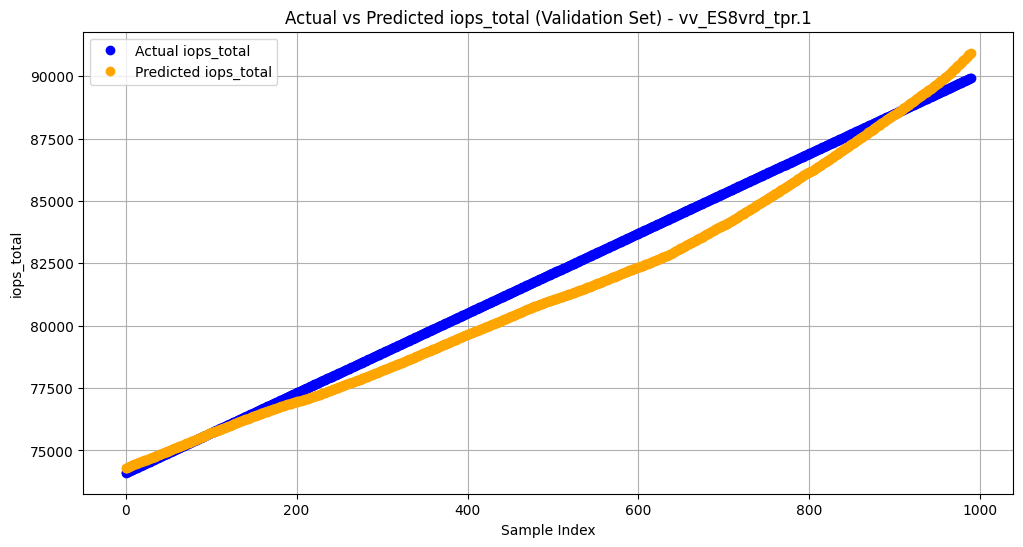


--- iops_total ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74278.8   74296.3   74315.125 74335.08  74354.27  74370.36  74386.52
 74402.43  74418.15  74433.85 ]

Validation Metrics for vv_ES8vrd_tpr.1 - Feature: latency
MSE: 20.7581, MAE: 3.8756, RMSE: 4.5561


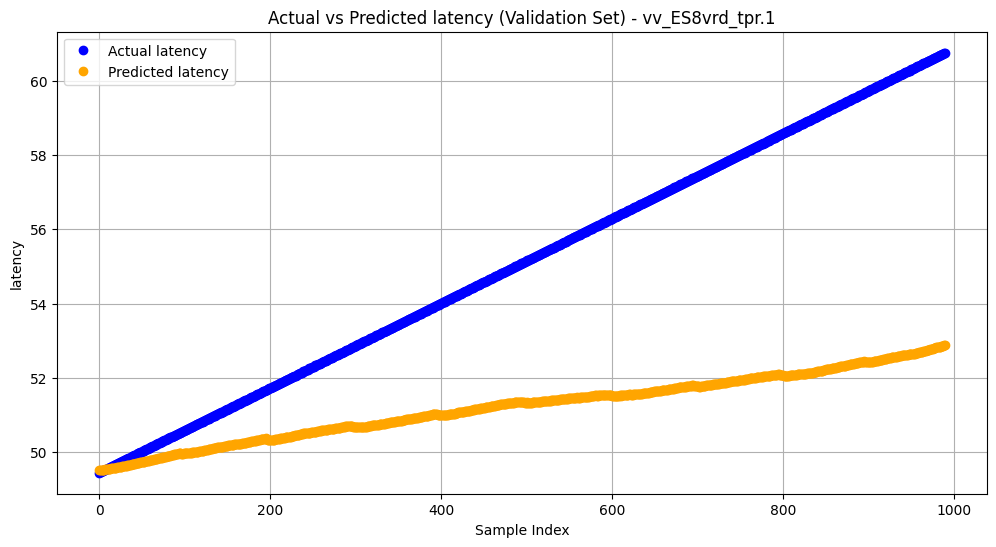


--- latency ---
Actual values (first 10 samples): [49.44 49.45 49.47 49.48 49.49 49.5  49.51 49.52 49.53 49.55]
Predicted values (first 10 samples): [49.506165 49.50786  49.5096   49.51304  49.517128 49.521847 49.52683
 49.53186  49.53695  49.542187]

Validation Metrics for vv_ES8vrd_tpr.1 - Feature: throughput
MSE: 656731.6420, MAE: 712.0932, RMSE: 810.3898


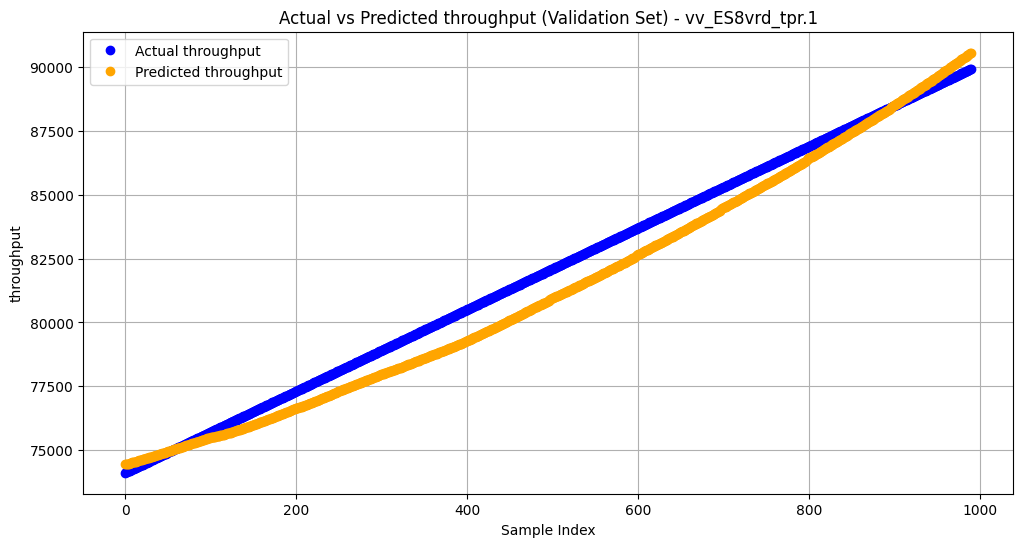


--- throughput ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74432.805 74435.914 74441.77  74450.945 74461.37  74473.38  74486.08
 74498.84  74511.67  74524.82 ]

Validation Metrics for vv_ES8vrd_tpr.1 - Feature: cpu_busy
MSE: 1.9874, MAE: 1.2448, RMSE: 1.4098


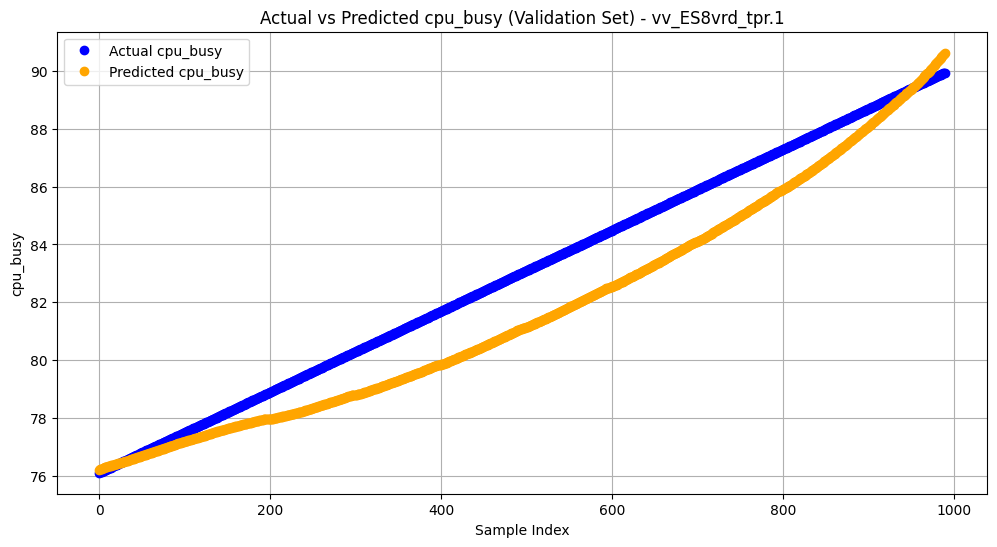


--- cpu_busy ---
Actual values (first 10 samples): [76.1  76.11 76.12 76.14 76.15 76.17 76.18 76.19 76.21 76.22]
Predicted values (first 10 samples): [76.20697  76.22105  76.23336  76.24566  76.257805 76.26983  76.28158
 76.29292  76.30392  76.31475 ]

Validation Metrics for vv_ES8vrd_tpr.1 - Feature: capacity_utilized
MSE: 0.6539, MAE: 0.6617, RMSE: 0.8087


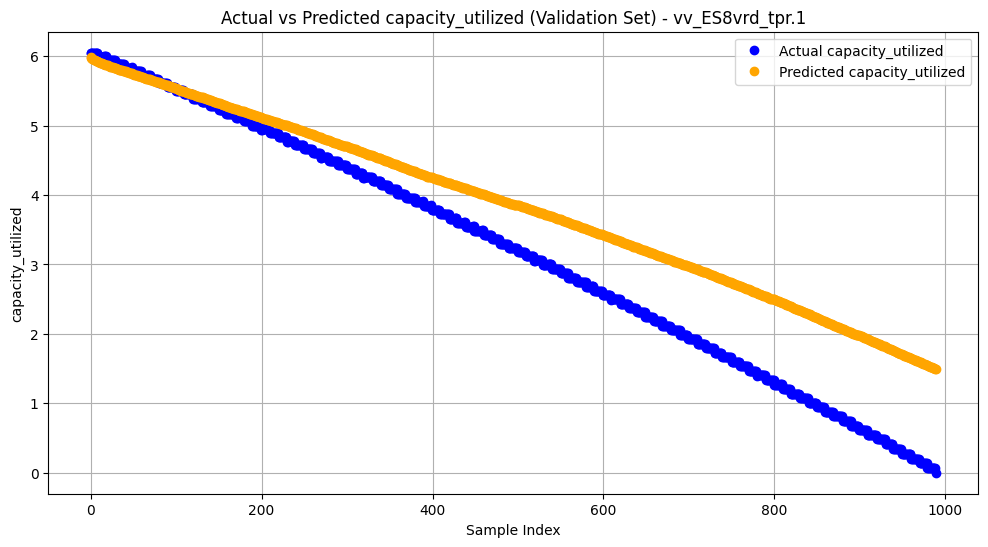


--- capacity_utilized ---
Actual values (first 10 samples): [6.04 6.04 6.05 6.05 6.05 6.05 6.05 6.05 6.05 5.99]
Predicted values (first 10 samples): [5.982467  5.973191  5.964415  5.9569116 5.950025  5.943608  5.9377985
 5.932452  5.9275403 5.9230647]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

Forecasted next 5 rows for generated_storage_data_vv_ES8vrd_tpr.1.csv:
   headroom  headroom_pct    iops_total    latency    throughput   cpu_busy  \
0  0.931104     57.165981  91107.921875  52.904949  90684.992188  90.806717   
1  0.960387     65.035721  96408.468750  63.568272  87527.335938  90.788132   
2  1.302600     51.408939  91306.312500  61.789791  80691.125000  87.732491   
3  0.448093     56.182392  89089.921875  59.020145  88693.726562  88.254303   
4  0.591385     58.112728  87903.445312  65.104790  91124.476562  91.717041   

   write_cache_miss  capacity_utilized       array_name  
0         10.270795           1.462034  vv_ES8vrd_tpr.1  
1         11.523422           3.345777  vv_ES8

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Validation Metrics for vv_ES8vrd_tpr.2:
MSE: 11596783.4495, MAE: 1523.6664, RMSE: 3405.4050


Validation Metrics for vv_ES8vrd_tpr.2 - Feature: iops_total
MSE: 47660282.2680, MAE: 6093.4363, RMSE: 6903.6427


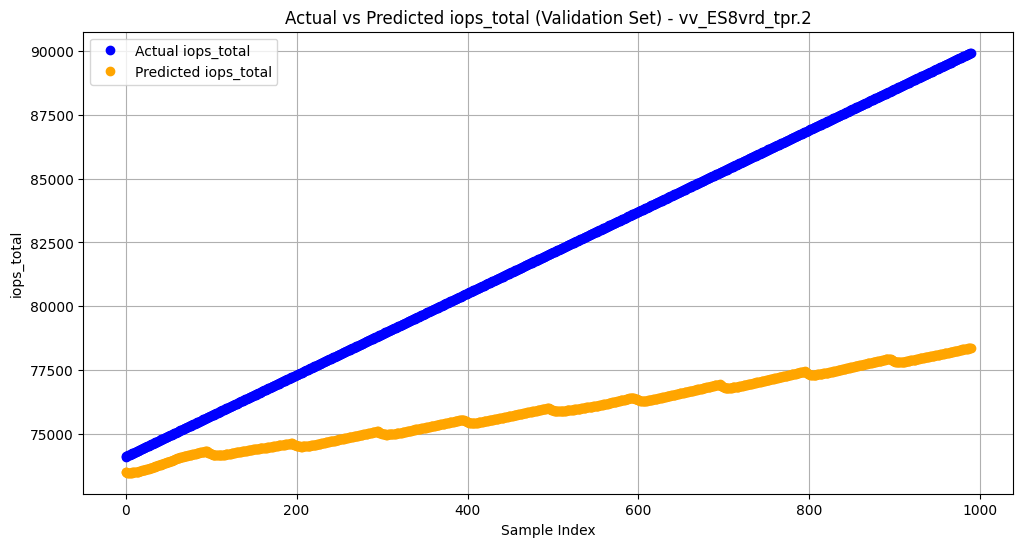


--- iops_total ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [73507.984 73492.63  73483.766 73479.766 73478.07  73478.2   73480.305
 73483.75  73488.414 73494.5  ]

Validation Metrics for vv_ES8vrd_tpr.2 - Feature: latency
MSE: 3.1562, MAE: 1.6384, RMSE: 1.7766


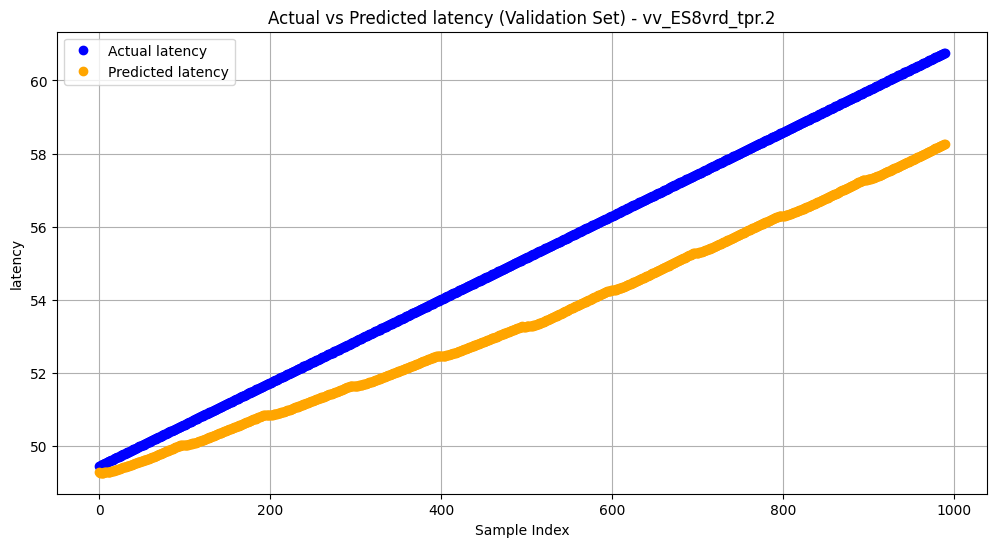


--- latency ---
Actual values (first 10 samples): [49.44 49.45 49.47 49.48 49.49 49.5  49.51 49.52 49.53 49.55]
Predicted values (first 10 samples): [49.26675  49.261818 49.26009  49.26059  49.261745 49.263645 49.26657
 49.27022  49.274574 49.279797]

Validation Metrics for vv_ES8vrd_tpr.2 - Feature: throughput
MSE: 45113869.3135, MAE: 6076.6108, RMSE: 6716.6859


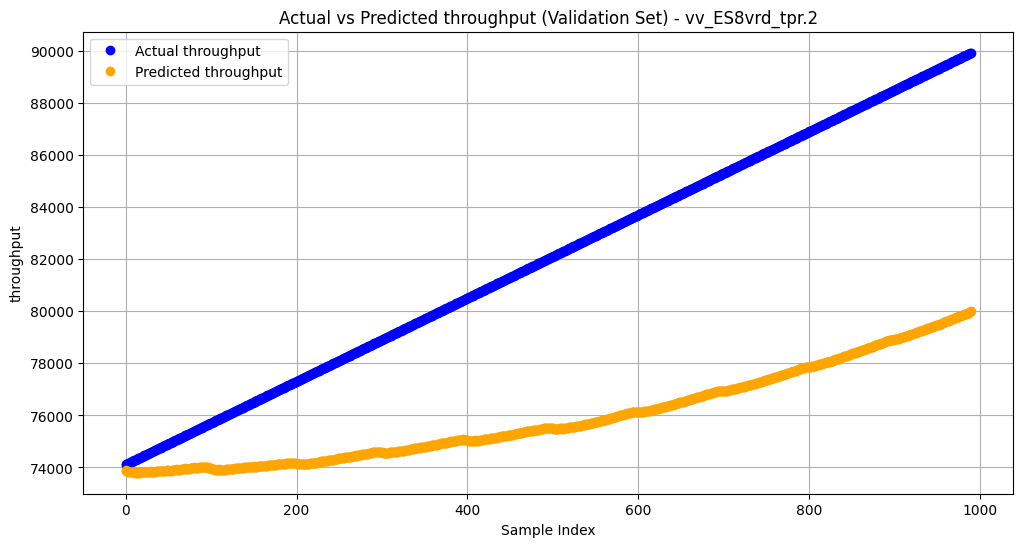


--- throughput ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [73890.66  73866.17  73849.48  73839.08  73831.24  73825.83  73823.05
 73822.15  73822.914 73825.586]

Validation Metrics for vv_ES8vrd_tpr.2 - Feature: cpu_busy
MSE: 14.4285, MAE: 3.3815, RMSE: 3.7985


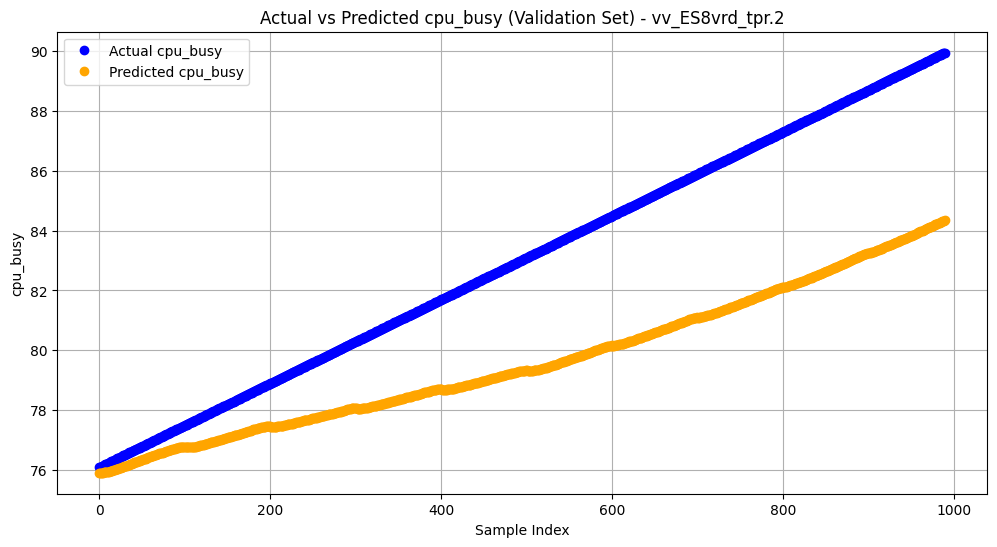


--- cpu_busy ---
Actual values (first 10 samples): [76.1  76.11 76.12 76.14 76.15 76.17 76.18 76.19 76.21 76.22]
Predicted values (first 10 samples): [75.91772  75.91381  75.91263  75.914185 75.917076 75.92098  75.92626
 75.93245  75.93951  75.947716]

Validation Metrics for vv_ES8vrd_tpr.2 - Feature: capacity_utilized
MSE: 5.3304, MAE: 1.9613, RMSE: 2.3088


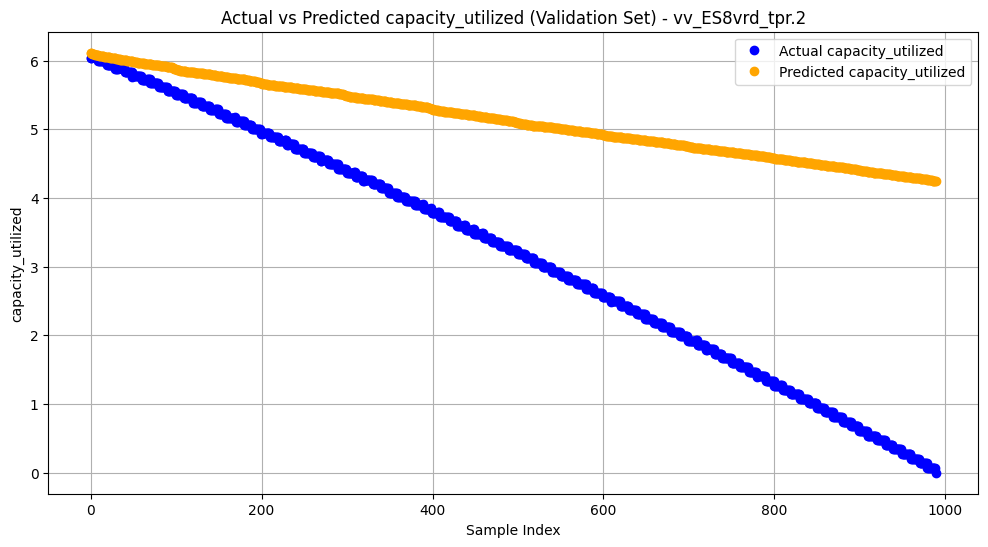


--- capacity_utilized ---
Actual values (first 10 samples): [6.04 6.04 6.05 6.05 6.05 6.05 6.05 6.05 6.05 5.99]
Predicted values (first 10 samples): [6.116401  6.1081877 6.101724  6.0969048 6.09283   6.0894856 6.08677
 6.084575  6.082813  6.081426 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Forecasted next 5 rows for generated_storage_data_vv_ES8vrd_tpr.2.csv:
   headroom  headroom_pct    iops_total    latency    throughput   cpu_busy  \
0  1.005417     63.017200  78402.656250  58.318501  80041.671875  84.404602   
1  1.215759     60.493183  80819.960938  53.990643  83853.226562  83.248009   
2  1.018347     57.938046  81767.734375  46.257286  85468.046875  96.196449   
3  0.920366     60.649258  84467.484375  52.847698  76663.617188  91.654938   
4  0.825058     59.157711  91338.750000  54.197868  80197.031250  81.216393   

   write_cache_miss  capacity_utilized       array_name  
0         15.113099           4.238169  vv_ES8vrd_tpr.2  
1         14.419690           5.428946  vv_ES8vr

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

Validation Metrics for vv_ES8vrd_tpr.3:
MSE: 2571333.1738, MAE: 544.7729, RMSE: 1603.5377


Validation Metrics for vv_ES8vrd_tpr.3 - Feature: iops_total
MSE: 19924443.6596, MAE: 3676.2503, RMSE: 4463.6805


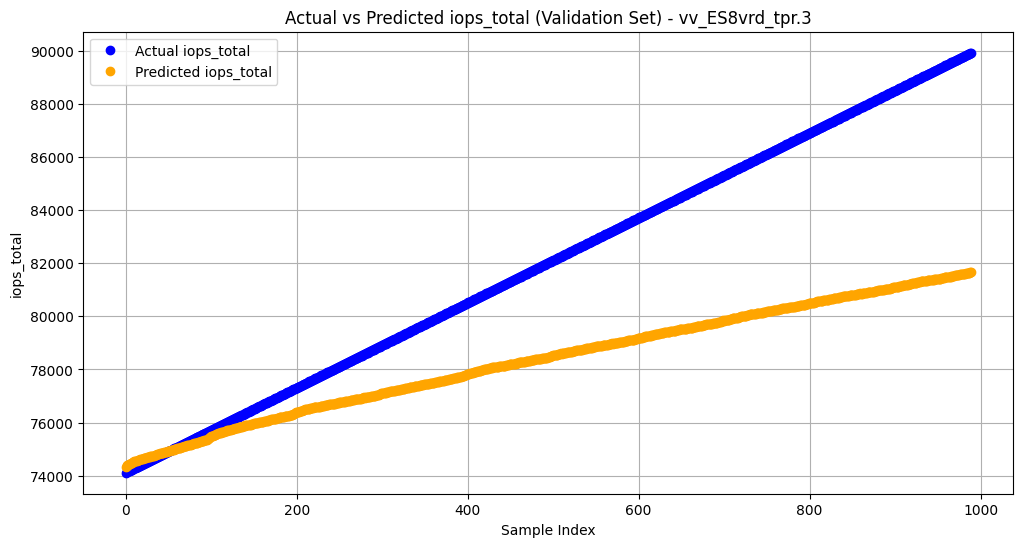


--- iops_total ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74336.69  74358.87  74380.8   74403.03  74424.53  74446.25  74467.766
 74488.086 74507.47  74525.72 ]

Validation Metrics for vv_ES8vrd_tpr.3 - Feature: latency
MSE: 3.8179, MAE: 1.5683, RMSE: 1.9539


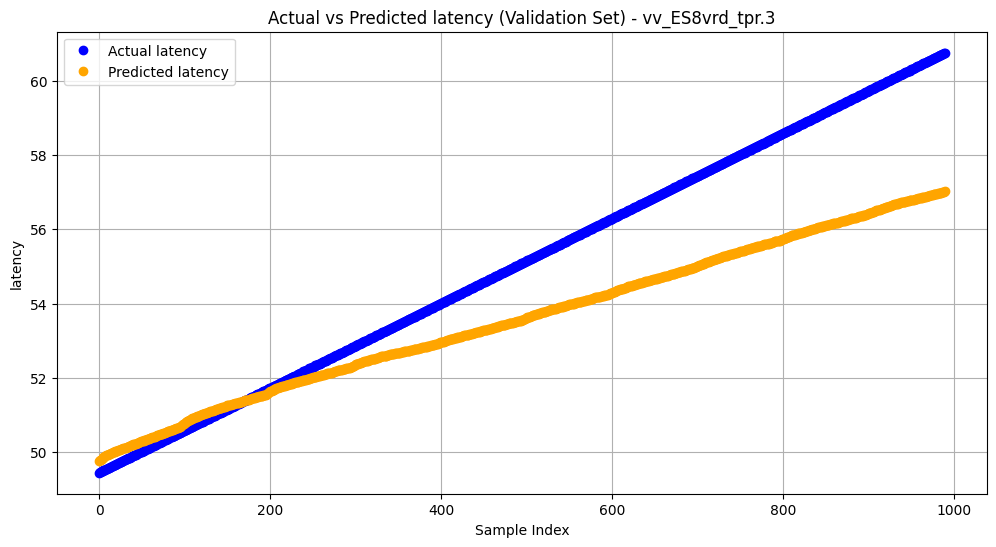


--- latency ---
Actual values (first 10 samples): [49.44 49.45 49.47 49.48 49.49 49.5  49.51 49.52 49.53 49.55]
Predicted values (first 10 samples): [49.747097 49.771324 49.79478  49.817722 49.839787 49.85828  49.87537
 49.891735 49.907516 49.92263 ]

Validation Metrics for vv_ES8vrd_tpr.3 - Feature: throughput
MSE: 646126.1648, MAE: 664.9240, RMSE: 803.8197


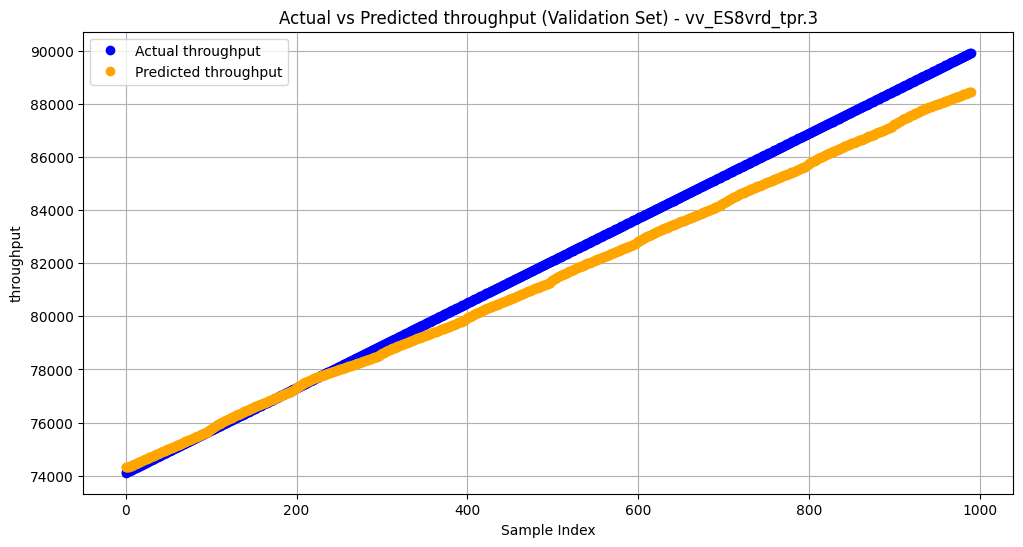


--- throughput ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74308.2   74311.086 74314.59  74321.84  74330.67  74344.266 74360.38
 74376.93  74393.84  74411.914]

Validation Metrics for vv_ES8vrd_tpr.3 - Feature: cpu_busy
MSE: 54.3924, MAE: 6.4080, RMSE: 7.3751


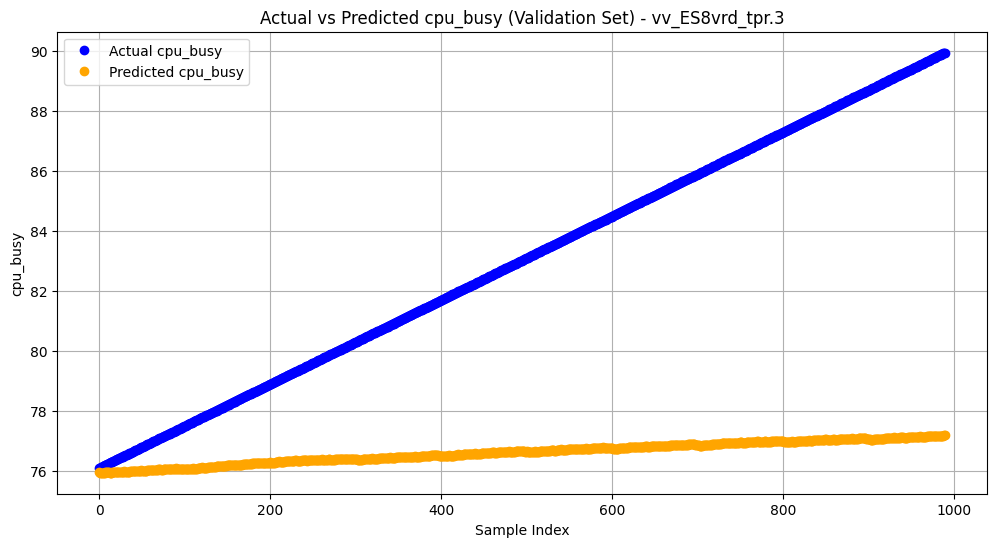


--- cpu_busy ---
Actual values (first 10 samples): [76.1  76.11 76.12 76.14 76.15 76.17 76.18 76.19 76.21 76.22]
Predicted values (first 10 samples): [75.95355  75.942986 75.93819  75.93883  75.94129  75.942726 75.94502
 75.94869  75.95359  75.96001 ]

Validation Metrics for vv_ES8vrd_tpr.3 - Feature: capacity_utilized
MSE: 4.2016, MAE: 1.7487, RMSE: 2.0498


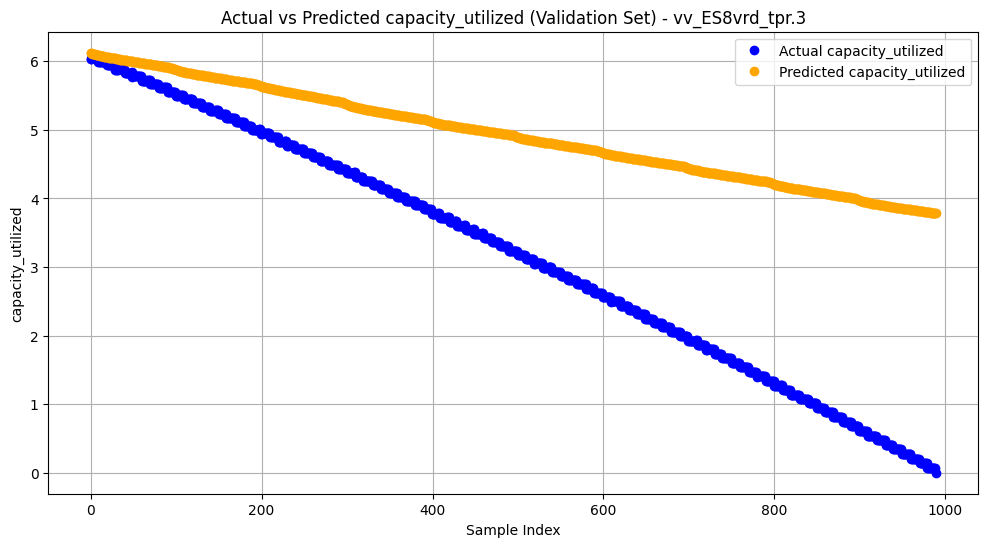


--- capacity_utilized ---
Actual values (first 10 samples): [6.04 6.04 6.05 6.05 6.05 6.05 6.05 6.05 6.05 5.99]
Predicted values (first 10 samples): [6.12615   6.1193285 6.113567  6.1087976 6.1043983 6.1012034 6.098696
 6.096408  6.094362  6.0924673]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Forecasted next 5 rows for generated_storage_data_vv_ES8vrd_tpr.3.csv:
   headroom  headroom_pct    iops_total    latency    throughput   cpu_busy  \
0  1.112803     56.593903  81691.039062  57.039581  88521.015625  77.179543   
1  1.288317     54.787521  79925.789062  60.306091  89196.453125  83.171997   
2  1.136539     61.392929  80881.421875  56.325748  87521.515625  76.947113   
3  0.920023     55.791962  85036.890625  59.180740  80709.859375  85.899620   
4  0.992126     60.056614  78629.945312  53.952572  79446.070312  88.813606   

   write_cache_miss  capacity_utilized       array_name  
0         12.750287           3.776509  vv_ES8vrd_tpr.3  
1         15.232795           3.512187  vv_ES8v

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step

Validation Metrics for vv_ES8vrd_tpr.4:
MSE: 1418948.0020, MAE: 450.8210, RMSE: 1191.1960


Validation Metrics for vv_ES8vrd_tpr.4 - Feature: iops_total
MSE: 1380663.1623, MAE: 1077.0413, RMSE: 1175.0162


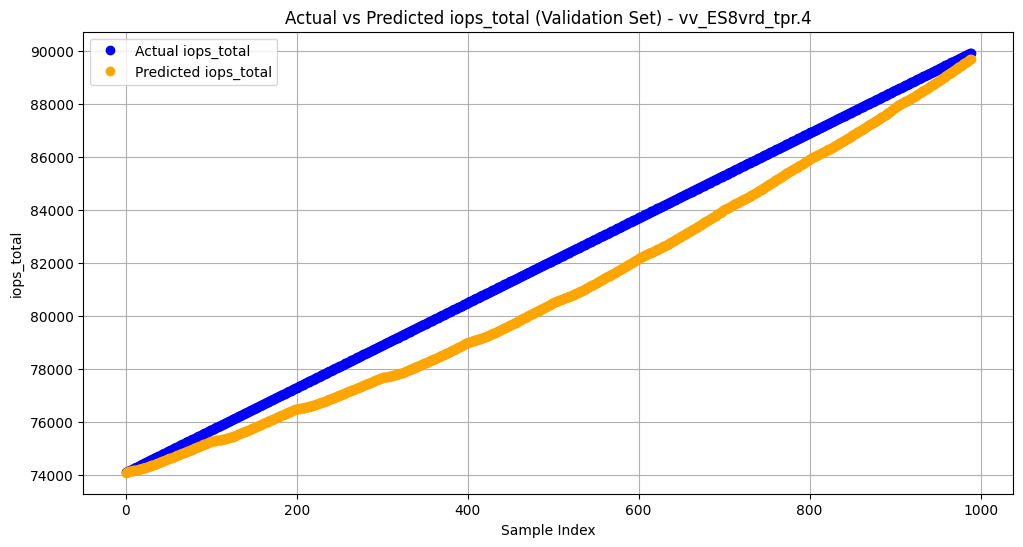


--- iops_total ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74098.87  74117.98  74131.445 74142.414 74151.63  74159.41  74166.75
 74173.695 74180.48  74188.375]

Validation Metrics for vv_ES8vrd_tpr.4 - Feature: latency
MSE: 1.0355, MAE: 0.8052, RMSE: 1.0176


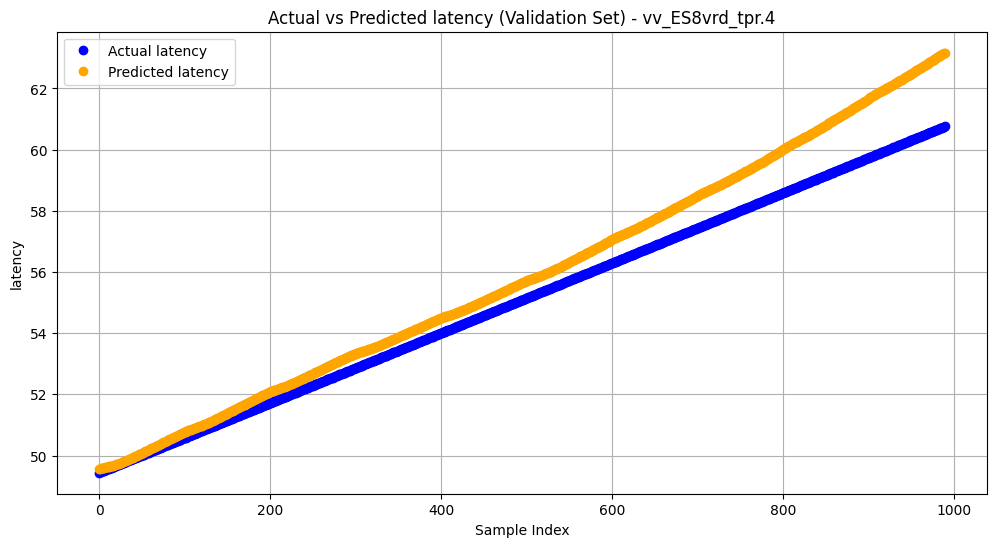


--- latency ---
Actual values (first 10 samples): [49.44 49.45 49.47 49.48 49.49 49.5  49.51 49.52 49.53 49.55]
Predicted values (first 10 samples): [49.56465  49.57587  49.58603  49.593086 49.59881  49.60418  49.609306
 49.614243 49.619183 49.62435 ]

Validation Metrics for vv_ES8vrd_tpr.4 - Feature: throughput
MSE: 9970758.5674, MAE: 2508.7526, RMSE: 3157.6508


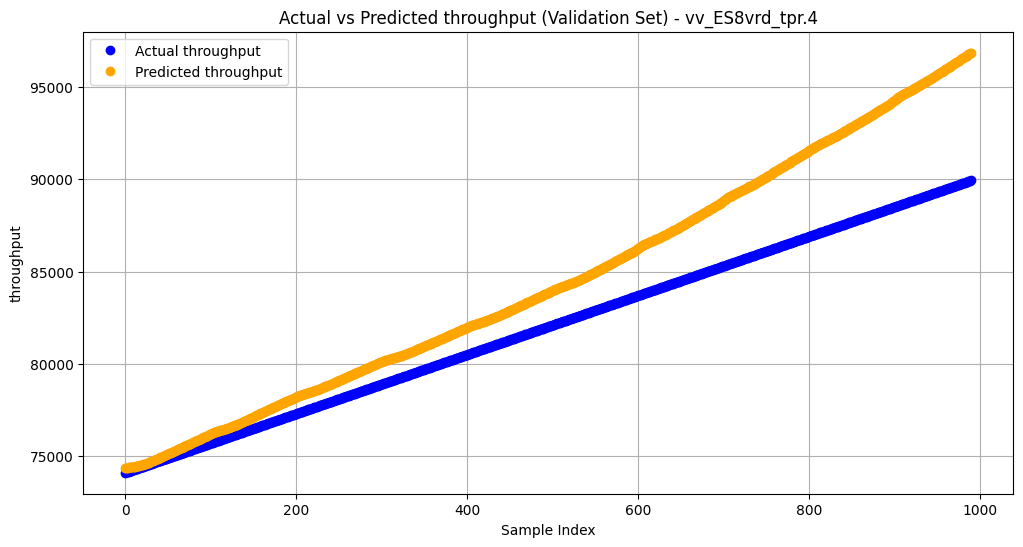


--- throughput ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74366.25  74374.23  74379.49  74387.086 74395.414 74403.42  74410.92
 74417.92  74425.    74432.86 ]

Validation Metrics for vv_ES8vrd_tpr.4 - Feature: cpu_busy
MSE: 8.1492, MAE: 2.6381, RMSE: 2.8547


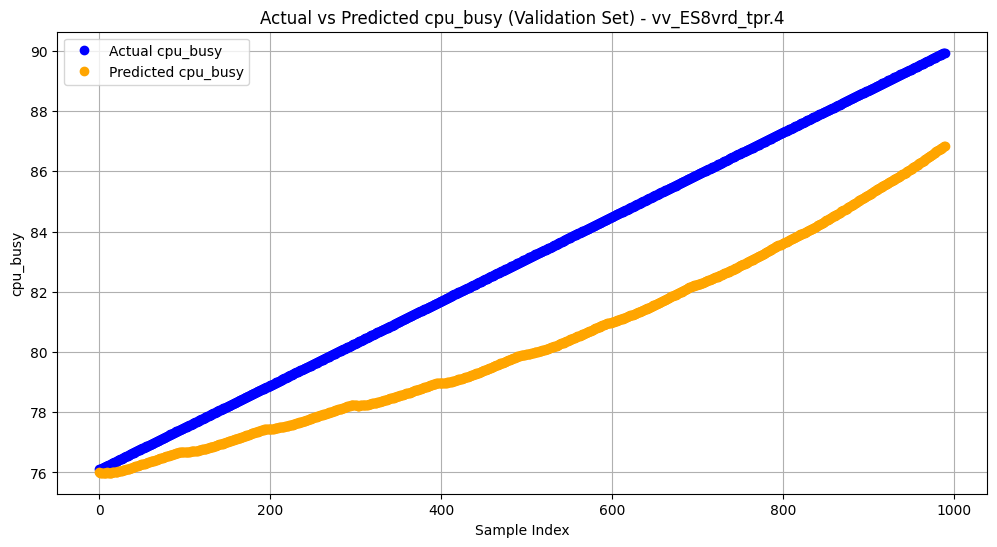


--- cpu_busy ---
Actual values (first 10 samples): [76.1  76.11 76.12 76.14 76.15 76.17 76.18 76.19 76.21 76.22]
Predicted values (first 10 samples): [75.99794  75.997025 75.99643  75.99534  75.99419  75.99378  75.99438
 75.9954   75.997055 75.99971 ]

Validation Metrics for vv_ES8vrd_tpr.4 - Feature: capacity_utilized
MSE: 10.4293, MAE: 2.7788, RMSE: 3.2294


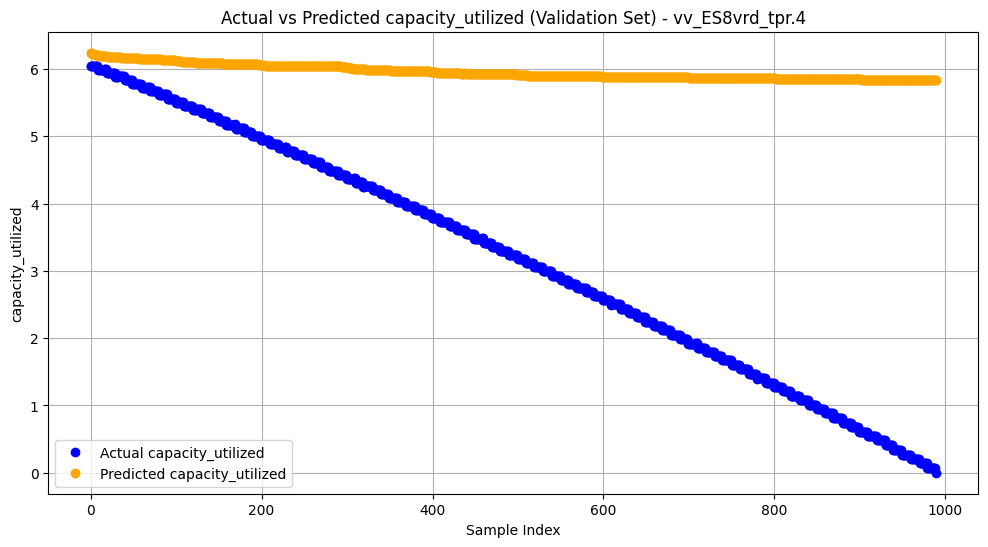


--- capacity_utilized ---
Actual values (first 10 samples): [6.04 6.04 6.05 6.05 6.05 6.05 6.05 6.05 6.05 5.99]
Predicted values (first 10 samples): [6.240755  6.232866  6.225966  6.2208524 6.216555  6.212844  6.2096615
 6.2068014 6.2043104 6.2021227]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Forecasted next 5 rows for generated_storage_data_vv_ES8vrd_tpr.4.csv:
   headroom  headroom_pct    iops_total    latency    throughput   cpu_busy  \
0  1.083971     68.683830  89820.445312  63.258232  97003.953125  86.942612   
1  0.839938     64.381294  92587.359375  63.970264  88255.367188  90.181839   
2  1.070433     58.677528  85585.992188  57.613194  86780.812500  94.335190   
3  0.963250     57.264908  95829.398438  51.482132  90084.421875  86.823936   
4  1.430833     60.158569  84132.632812  63.568966  95572.515625  83.040596   

   write_cache_miss  capacity_utilized       array_name  
0         17.007294           5.838065  vv_ES8vrd_tpr.4  
1         14.942507           6.128426  vv_ES8

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

Validation Metrics for vv_ES8vrd_tpr.5:
MSE: 2959499.1326, MAE: 796.9693, RMSE: 1720.3195


Validation Metrics for vv_ES8vrd_tpr.5 - Feature: iops_total
MSE: 14198057.0877, MAE: 3497.9557, RMSE: 3768.0309


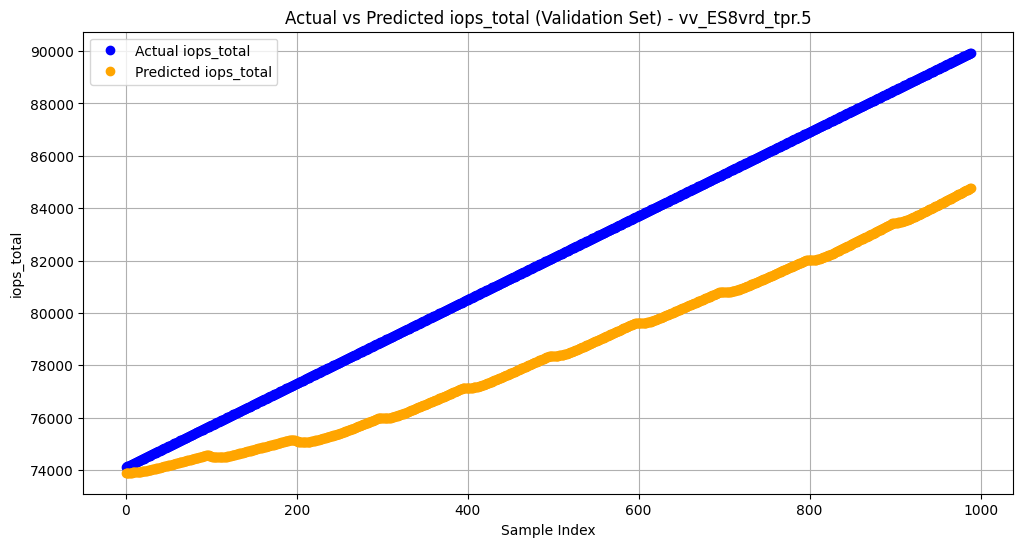


--- iops_total ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [73901.38  73904.836 73905.65  73905.37  73905.35  73905.48  73906.67
 73908.53  73911.26  73916.05 ]

Validation Metrics for vv_ES8vrd_tpr.5 - Feature: latency
MSE: 2.3828, MAE: 1.1404, RMSE: 1.5436


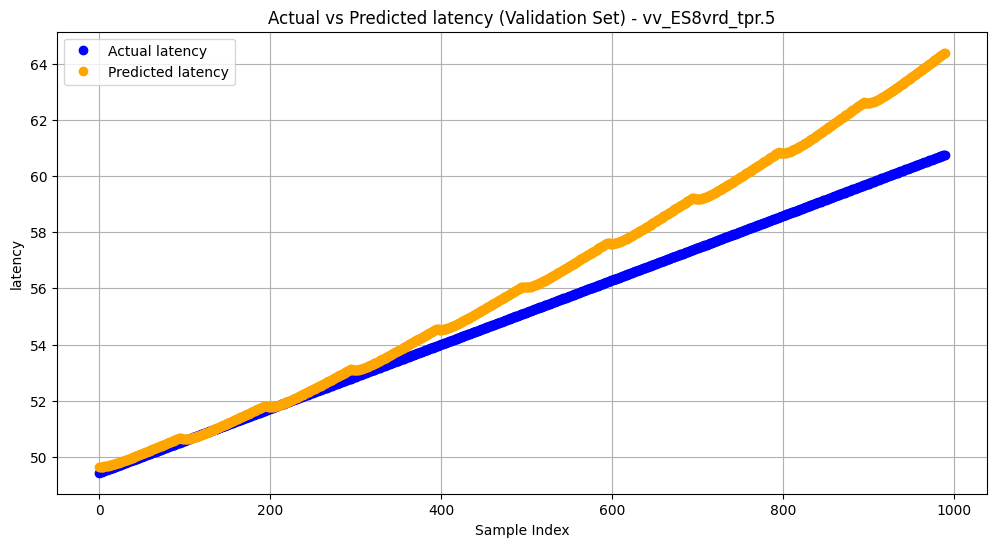


--- latency ---
Actual values (first 10 samples): [49.44 49.45 49.47 49.48 49.49 49.5  49.51 49.52 49.53 49.55]
Predicted values (first 10 samples): [49.657425 49.655888 49.65551  49.65641  49.658375 49.66119  49.665062
 49.669685 49.67499  49.6817  ]

Validation Metrics for vv_ES8vrd_tpr.5 - Feature: throughput
MSE: 9477867.9231, MAE: 2863.0165, RMSE: 3078.6146


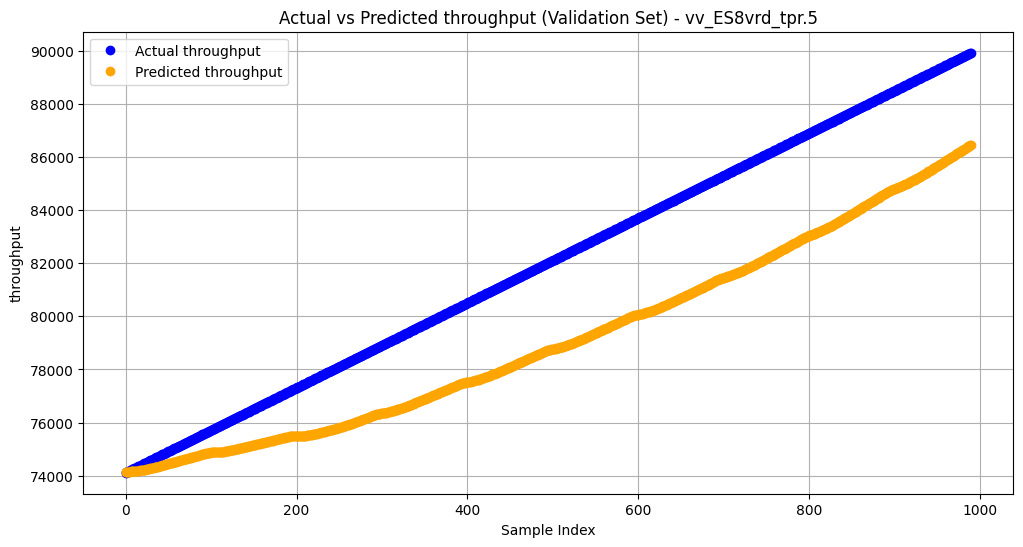


--- throughput ---
Actual values (first 10 samples): [74108. 74124. 74140. 74156. 74172. 74188. 74204. 74220. 74236. 74252.]
Predicted values (first 10 samples): [74132.07  74135.91  74140.336 74144.46  74147.695 74150.86  74154.65
 74158.96  74163.83  74168.96 ]

Validation Metrics for vv_ES8vrd_tpr.5 - Feature: cpu_busy
MSE: 11.2935, MAE: 3.0250, RMSE: 3.3606


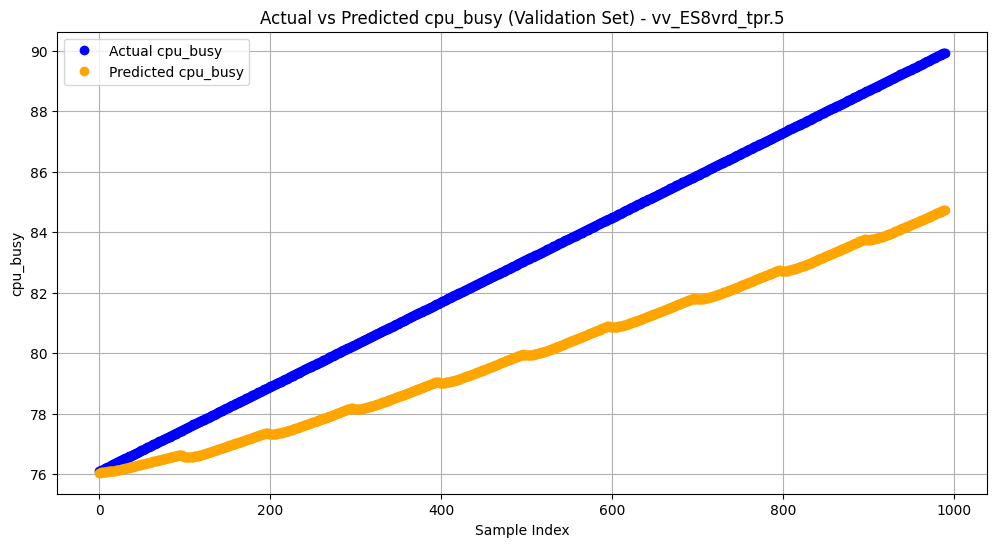


--- cpu_busy ---
Actual values (first 10 samples): [76.1  76.11 76.12 76.14 76.15 76.17 76.18 76.19 76.21 76.22]
Predicted values (first 10 samples): [76.044174 76.0482   76.05209  76.05606  76.06006  76.06401  76.06767
 76.07144  76.075615 76.081055]

Validation Metrics for vv_ES8vrd_tpr.5 - Feature: capacity_utilized
MSE: 6.9114, MAE: 2.2301, RMSE: 2.6289


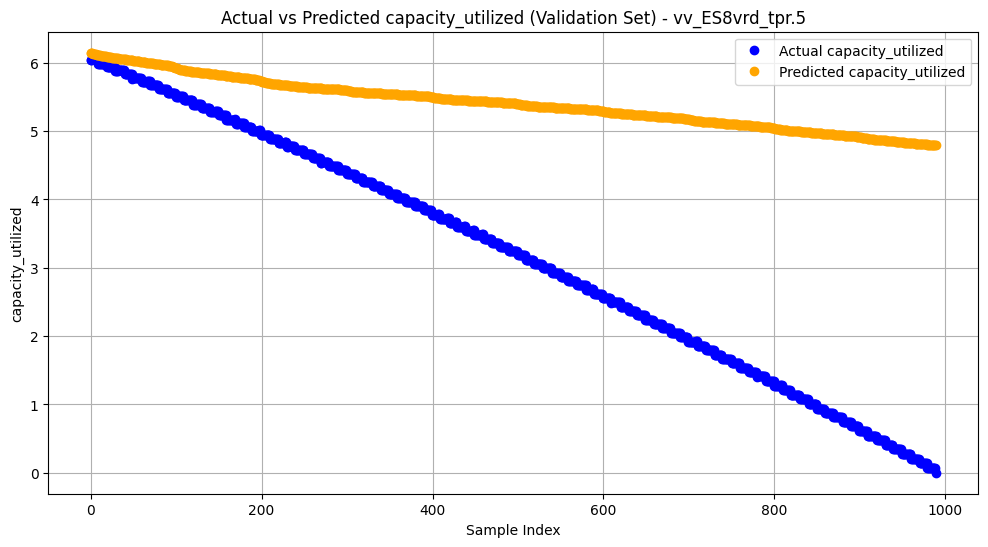


--- capacity_utilized ---
Actual values (first 10 samples): [6.04 6.04 6.05 6.05 6.05 6.05 6.05 6.05 6.05 5.99]
Predicted values (first 10 samples): [6.1483855 6.1423783 6.13725   6.133178  6.1295314 6.126287  6.123313
 6.1206293 6.1182303 6.116387 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Forecasted next 5 rows for generated_storage_data_vv_ES8vrd_tpr.5.csv:
   headroom  headroom_pct    iops_total    latency    throughput   cpu_busy  \
0  1.244036     60.829430  84867.523438  64.499413  86574.976562  84.809708   
1  0.823833     51.716812  91630.851562  56.708027  85024.242188  87.013718   
2  0.374590     58.350147  82348.625000  63.142151  91515.343750  83.677818   
3  0.986402     60.516071  92245.937500  56.574749  91641.781250  82.670982   
4  0.881540     53.815395  94475.289062  58.967194  93093.179688  85.299408   

   write_cache_miss  capacity_utilized       array_name  
0         10.151737           4.782258  vv_ES8vrd_tpr.5  
1          8.375237           4.174050  vv_ES8v

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Function to create sequences from the data (X, Y)
def create_sequences(data, seq_length, forecast_steps):
    X = []
    Y = []
    for i in range(len(data) - seq_length - forecast_steps + 1):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length:i+seq_length+forecast_steps])  # Forecast next 'forecast_steps' rows
    return np.array(X), np.array(Y)

# Function to train and forecast using LSTM model
def train_and_forecast(data_path, seq_length=50, forecast_steps=5, features=None):
    # Load the data
    df = pd.read_csv(data_path)

    if features is None:
        features = ['headroom', 'headroom_pct', 'iops_total', 'latency', 'throughput', 'cpu_busy', 'write_cache_miss', 'capacity_utilized']

    # Extract array_name from the CSV
    array_name = df['array_name'].iloc[0]

    # Selecting the features for training
    data = df[features]

    # Normalize the features
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, Y = create_sequences(scaled_data, seq_length, forecast_steps)

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(forecast_steps * len(features)))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train.reshape(Y_train.shape[0], -1), epochs=20, batch_size=32,
              validation_data=(X_test, Y_test.reshape(Y_test.shape[0], -1)), verbose=0)

    # Validation: Predict on test set and compute metrics
    Y_test_pred = model.predict(X_test)
    Y_test_pred_reshaped = Y_test_pred.reshape(-1, forecast_steps, len(features))
    Y_test_pred_first_step = scaler.inverse_transform(Y_test_pred_reshaped[:, 0, :])
    Y_test_true_first_step = scaler.inverse_transform(Y_test[:, 0, :])
    #Y_test_pred_rescaled = scaler.inverse_transform(Y_test_pred.reshape(-1, len(features)))
    #Y_test_true_rescaled = scaler.inverse_transform(Y_test.reshape(-1, len(features)))

    mse = mean_squared_error(Y_test_true_first_step, Y_test_pred_first_step)
    mae = mean_absolute_error(Y_test_true_first_step, Y_test_pred_first_step)
    rmse = np.sqrt(mse)

    print(f"\nValidation Metrics for {array_name}:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}\n")

    #features = ['headroom', 'headroom_pct', 'latency', 'throughput', 'cpu_busy', 'write_cache_miss']
    for idx, feature in enumerate(features):
      if(feature=="headroom") or (feature=="headroom_pct") or (feature=="write_cache_miss"):
        continue
      mse = mean_squared_error(Y_test_true_first_step[:, idx], Y_test_pred_first_step[:, idx])
      mae = mean_absolute_error(Y_test_true_first_step[:, idx], Y_test_pred_first_step[:, idx])
      rmse = np.sqrt(mse)

      print(f"\nValidation Metrics for {array_name} - Feature: {feature}")
      print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

      # Plotting only dots
      plt.figure(figsize=(12, 6))
      plt.plot(Y_test_true_first_step[:, idx], label=f'Actual {feature}', color='blue', marker='o', linestyle='None')
      plt.plot(Y_test_pred_first_step[:, idx], label=f'Predicted {feature}', color='orange', marker='o', linestyle='None')
      plt.title(f'Actual vs Predicted {feature} (Validation Set) - {array_name}')
      plt.xlabel('Sample Index')
      plt.ylabel(feature)
      plt.legend()
      plt.grid(True)
      plt.show()

      print(f"\n--- {feature} ---")
      print("Actual values (first 10 samples):", Y_test_true_first_step[:, idx][:10])
      print("Predicted values (first 10 samples):", Y_test_pred_first_step[:, idx][:10])


    # Forecast the next 5 rows
    def forecast(model, data, seq_length, forecast_steps):
        input_seq = data[-seq_length:].reshape(1, seq_length, len(features))
        prediction = model.predict(input_seq)
        predicted_values = scaler.inverse_transform(prediction[0].reshape(forecast_steps, len(features)))
        return predicted_values

    forecasted_values = forecast(model, scaled_data, seq_length, forecast_steps)

    forecasted_df = pd.DataFrame(forecasted_values, columns=features)
    forecasted_df['array_name'] = array_name

    return forecasted_df

# List of datasets (5 arrays)
datasets = [
    'generated_storage_data_vv_ES8vrd_tpr.1.csv',
    'generated_storage_data_vv_ES8vrd_tpr.2.csv',
    'generated_storage_data_vv_ES8vrd_tpr.3.csv',
    'generated_storage_data_vv_ES8vrd_tpr.4.csv',
    'generated_storage_data_vv_ES8vrd_tpr.5.csv'
]

# Iterate over all datasets
for i, dataset in enumerate(datasets, 1):
    print(f"\nForecasting for {dataset}...")
    forecasted_data = train_and_forecast(dataset)
    print(f"\nForecasted next 5 rows for {dataset}:")
    print(forecasted_data)

    # Save forecasted data
    forecasted_data.to_csv(f"forecasted_{i}.csv", index=False)
    print(f"Forecasted data saved to 'forecasted_{i}.csv'\n")


# **Hotness and Coldness Score**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to compute the hotness score based on selected parameters
def compute_hotness_score(forecasted_data, features=["capacity_utilized", "iops_total", "throughput"]):
    # Normalize the selected features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(forecasted_data[features])

    # Compute a simple hotness score by summing the normalized values
    hotness_score = np.sum(scaled_data, axis=1)  # Sum across the features (axis=1 for rows)

    return hotness_score

# Function to classify arrays as hot or cold based on hotness score
def classify_arrays(datasets, features=["capacity_utilized", "iops_total", "throughput"]):
    hotness_scores = {}

    # Iterate through all forecasted datasets to compute hotness score
    for i, dataset in enumerate(datasets, 1):
        # Load the forecasted data from the CSV file generated earlier
        forecasted_data = pd.read_csv(dataset)

        # Extract the array name (assuming the column name is "array_name")
        array_name = forecasted_data['array_name'].iloc[0]  # Extracting the name from the first row

        # Compute hotness score
        hotness_score = compute_hotness_score(forecasted_data, features)

        # Store hotness scores for each dataset using the array name
        hotness_scores[array_name] = np.mean(hotness_score)  # Using mean score as representative

    # Sort arrays by hotness score
    sorted_arrays = sorted(hotness_scores.items(), key=lambda x: x[1], reverse=True)

    # Identify hottest and coldest arrays
    hottest_array = sorted_arrays[0]
    coldest_array = sorted_arrays[-1]

    return hottest_array, coldest_array, sorted_arrays

# List of datasets (5 arrays)
datasets = [
    'forecasted_1.csv',
    'forecasted_2.csv',
    'forecasted_3.csv',
    'forecasted_4.csv',
    'forecasted_5.csv'
]

# Classify arrays and get hottest and coldest
hottest_array, coldest_array, sorted_arrays = classify_arrays(datasets)

print(f"Hottest array: {hottest_array}")
print(f"Coldest array: {coldest_array}")
print("\nAll arrays sorted by hotness score:")

# Print all arrays sorted by hotness score, including the array name
for array_name, score in sorted_arrays:
    print(f"Array: {array_name}, Hotness score: {score}")


Hottest array: ('vv_ES8vrd_tpr.1', np.float64(1.6858569651104953))
Coldest array: ('vv_ES8vrd_tpr.2', np.float64(1.363158800796994))

All arrays sorted by hotness score:
Array: vv_ES8vrd_tpr.1, Hotness score: 1.6858569651104953
Array: vv_ES8vrd_tpr.5, Hotness score: 1.664844970177412
Array: vv_ES8vrd_tpr.4, Hotness score: 1.6131048438957882
Array: vv_ES8vrd_tpr.3, Hotness score: 1.3714552324598759
Array: vv_ES8vrd_tpr.2, Hotness score: 1.363158800796994


# **DRL**

In [ ]:
# Install the libraries required for DRL
# Gymnasium is the new version of OpenAI Gym
# Stable-Baselines3 is the library for DRL agents (like DQN)
!pip install gymnasium stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 11.8 MB/s eta 0:00:00


# **Custom Gym Environment**

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import glob

print("\n--- Starting Objective 4/5: DRL Implementation ---")

class DataCenterEnv(gym.Env):
    """
    Custom Gym Environment for Data Center Energy Optimization.
    [RE-BALANCED REWARDS]
    """
    def __init__(self, forecast_dataframes_list):
        super(DataCenterEnv, self).__init__()

        # Load all forecast CSVs created by the LSTM
        self.forecast_data_list = [pd.read_csv(f) for f in forecast_dataframes_list]
        self.current_forecast = None
        self.current_step = 0

        # Define Action Space (4 discrete actions)
        self.action_space = spaces.Discrete(4)

        # Define Observation Space (State)
        self.obs_features = ['capacity_utilized', 'iops_total', 'throughput']
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(self.obs_features),), dtype=np.float32)

    def _get_obs(self):
        obs = self.current_forecast[self.obs_features].iloc[self.current_step].values
        return obs.astype(np.float32)

    def reset(self, seed=None):
        super().reset(seed=seed)
        # Select a random forecast scenario (one of the 5 arrays)
        self.current_forecast = self.forecast_data_list[np.random.randint(len(self.forecast_data_list))].copy()
        self.current_step = 0
        return self._get_obs(), {}

    def step(self, action):
        # 1. Get state
        current_workload = self._get_obs()
        workload_capacity = current_workload[0]
        workload_iops = current_workload[1]
        workload_throughput = current_workload[2]

        # 2. Simulate action effect
        if action == 0:   # Low CPU, Low Cooling
            cpu_freq_factor = 0.5; cooling_power = 50
        elif action == 1: # Low CPU, High Cooling
            cpu_freq_factor = 0.5; cooling_power = 100
        elif action == 2: # High CPU, Low Cooling
            cpu_freq_factor = 1.0; cooling_power = 50
        else: # 3: High CPU, High Cooling
            cpu_freq_factor = 1.0; cooling_power = 100

        # 3. Simulate Power Consumption (RE-BALANCED)
        # We divide by 100, not 10,000, to make the power cost larger and more meaningful.
        power_cpu = (cpu_freq_factor**2) * (workload_iops / 10.0) # <-- CHANGE
        total_power_consumption = power_cpu + cooling_power

        # 4. Simulate Penalties (RE-BALANCED)
        performance_capacity = 90000 * cpu_freq_factor
        overload_penalty = 0

        # We divide the penalty to make it smaller and more proportional.
        if workload_throughput > performance_capacity:
              overload_penalty = (workload_throughput - performance_capacity) / 1000.0 # <-- CHANGE / 100.0 # <-- FIX

        # We also scale the cooling penalty.
        if workload_capacity > 5.0 and cooling_power < 100:
             overload_penalty += (workload_capacity * 10) / 10.0 # <-- FIX

        # 5. Calculate Reward (Negative cost)
        reward = -(total_power_consumption + overload_penalty)

        # 6. Update state
        self.current_step += 1
        done = self.current_step >= (len(self.current_forecast))
        next_obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)

        return next_obs, reward, done, False, {}

print("Custom Gym Environment 'DataCenterEnv' created with RE-BALANCED rewards.")


--- Starting Objective 4/5: DRL Implementation ---
Custom Gym Environment 'DataCenterEnv' created with RE-BALANCED rewards.


# **Trains a Deep Q-Network (DQN) agent**

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import glob

# Find all forecast files
forecast_files = glob.glob("forecasted_*.csv")
if not forecast_files:
    print("Error: 'forecasted_*.csv' files not found. Please run Step 2 first.")
else:
    print(f"Found {len(forecast_files)} forecast files for DRL training.")

    # Create the environment using the RE-BALANCED class
    env = make_vec_env(DataCenterEnv, n_envs=1, env_kwargs={'forecast_dataframes_list': forecast_files})

    # Instantiate the DQN model
    model = DQN("MlpPolicy", env,
                verbose=1,
                learning_starts=500,
                buffer_size=5000,
                train_freq=(1, "step"),
                target_update_interval=1000,
                learning_rate=0.001)

    # --- THIS IS THE UPGRADED LINE ---
    # Train for 100,000 steps for a high-quality result
    print("\n--- Starting DRL Agent Training (100,000 steps) ---")
    model.learn(total_timesteps=100000, log_interval=100)
    print("--- DRL Agent Training Complete ---")

    # Save the new, smarter model
    model.save("dqn_datacenter_agent_100k")
    print("Trained DRL model saved as 'dqn_datacenter_agent_100k.zip'")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Found 5 forecast files for DRL training.
Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- Starting DRL Agent Training (100,000 steps) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.68e+04 |
|    exploration_rate | 0.952     |
| time/               |           |
|    episodes         | 100       |
|    fps              | 696       |
|    time_elapsed     | 0         |
|    total_timesteps  | 500       |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.61e+04 |
|    exploration_rate | 0.905     |
| time/               |           |
|    episodes         | 200       |
|    fps              | 301       |
|    time_elapsed     | 3         |
|    total_timesteps  | 1000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 801       |
|    n_updates        | 499       |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -2.6e+04 |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 278      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1500     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 560      |
|    n_updates        | 999      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -2.4e+04 |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 266      |
|    time_elapsed     | 7        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 458      |
|    n_updates        | 1499     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.44e+04 |
|    exploration_rate | 0.762     |
| time/               |           |
|    episodes         | 500       |
|    fps              | 258       |
|    time_elapsed     | 9         |
|    total_timesteps  | 2500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 332       |
|    n_updates        | 1999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.29e+04 |
|    exploration_rate | 0.715     |
| time/               |           |
|    episodes         | 600       |
|    fps              | 254       |
|    time_elapsed     | 11        |
|    total_timesteps  | 3000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 254       |
|    n_updates        | 2499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.24e+04 |
|    exploration_rate | 0.667     |
| time/               |           |
|    episodes         | 700       |
|    fps              | 239       |
|    time_elapsed     | 14        |
|    total_timesteps  | 3500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.06e+03  |
|    n_updates        | 2999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -2.34e+04 |
|    exploration_rate | 0.62      |
| time/               |           |
|    episodes         | 800       |
|    fps              | 236       |
|    time_elapsed     | 16        |
|    total_timesteps  | 4000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.06e+03  |
|    n_updates        | 3499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -2.1e+04 |
|    exploration_rate | 0.572    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 236      |
|    time_elapsed     | 19       |
|    total_timesteps  | 4500     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 668      |
|    n_updates        | 3999     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.99e+04 |
|    exploration_rate | 0.525     |
| time/               |           |
|    episodes         | 1000      |
|    fps              | 237       |
|    time_elapsed     | 21        |
|    total_timesteps  | 5000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.41e+03  |
|    n_updates        | 4499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.86e+04 |
|    exploration_rate | 0.477     |
| time/               |           |
|    episodes         | 1100      |
|    fps              | 237       |
|    time_elapsed     | 23        |
|    total_timesteps  | 5500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.31e+03  |
|    n_updates        | 4999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.81e+04 |
|    exploration_rate | 0.43      |
| time/               |           |
|    episodes         | 1200      |
|    fps              | 235       |
|    time_elapsed     | 25        |
|    total_timesteps  | 6000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.24e+03  |
|    n_updates        | 5499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.77e+04 |
|    exploration_rate | 0.383     |
| time/               |           |
|    episodes         | 1300      |
|    fps              | 229       |
|    time_elapsed     | 28        |
|    total_timesteps  | 6500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.92e+03  |
|    n_updates        | 5999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.71e+04 |
|    exploration_rate | 0.335     |
| time/               |           |
|    episodes         | 1400      |
|    fps              | 229       |
|    time_elapsed     | 30        |
|    total_timesteps  | 7000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.36e+03  |
|    n_updates        | 6499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.56e+04 |
|    exploration_rate | 0.288     |
| time/               |           |
|    episodes         | 1500      |
|    fps              | 230       |
|    time_elapsed     | 32        |
|    total_timesteps  | 7500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.57e+03  |
|    n_updates        | 6999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.51e+04 |
|    exploration_rate | 0.24      |
| time/               |           |
|    episodes         | 1600      |
|    fps              | 223       |
|    time_elapsed     | 35        |
|    total_timesteps  | 8000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.95e+03  |
|    n_updates        | 7499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.52e+04 |
|    exploration_rate | 0.193     |
| time/               |           |
|    episodes         | 1700      |
|    fps              | 221       |
|    time_elapsed     | 38        |
|    total_timesteps  | 8500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.11e+03  |
|    n_updates        | 7999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.43e+04 |
|    exploration_rate | 0.145     |
| time/               |           |
|    episodes         | 1800      |
|    fps              | 219       |
|    time_elapsed     | 40        |
|    total_timesteps  | 9000      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.25e+03  |
|    n_updates        | 8499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.34e+04 |
|    exploration_rate | 0.0975    |
| time/               |           |
|    episodes         | 1900      |
|    fps              | 220       |
|    time_elapsed     | 43        |
|    total_timesteps  | 9500      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.89e+03  |
|    n_updates        | 8999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2000      |
|    fps              | 220       |
|    time_elapsed     | 45        |
|    total_timesteps  | 10000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.48e+03  |
|    n_updates        | 9499      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2100      |
|    fps              | 220       |
|    time_elapsed     | 47        |
|    total_timesteps  | 10500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.5e+03   |
|    n_updates        | 9999      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2200      |
|    fps              | 220       |
|    time_elapsed     | 49        |
|    total_timesteps  | 11000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.3e+03   |
|    n_updates        | 10499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2300      |
|    fps              | 218       |
|    time_elapsed     | 52        |
|    total_timesteps  | 11500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.37e+03  |
|    n_updates        | 10999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2400      |
|    fps              | 218       |
|    time_elapsed     | 54        |
|    total_timesteps  | 12000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.59e+03  |
|    n_updates        | 11499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2500      |
|    fps              | 218       |
|    time_elapsed     | 57        |
|    total_timesteps  | 12500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.17e+03  |
|    n_updates        | 11999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2600      |
|    fps              | 218       |
|    time_elapsed     | 59        |
|    total_timesteps  | 13000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.99e+03  |
|    n_updates        | 12499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2700      |
|    fps              | 219       |
|    time_elapsed     | 61        |
|    total_timesteps  | 13500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.25e+03  |
|    n_updates        | 12999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2800      |
|    fps              | 217       |
|    time_elapsed     | 64        |
|    total_timesteps  | 14000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.55e+03  |
|    n_updates        | 13499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 2900      |
|    fps              | 217       |
|    time_elapsed     | 66        |
|    total_timesteps  | 14500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.9e+03   |
|    n_updates        | 13999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3000      |
|    fps              | 217       |
|    time_elapsed     | 69        |
|    total_timesteps  | 15000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.57e+03  |
|    n_updates        | 14499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3100      |
|    fps              | 217       |
|    time_elapsed     | 71        |
|    total_timesteps  | 15500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.98e+03  |
|    n_updates        | 14999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3200      |
|    fps              | 217       |
|    time_elapsed     | 73        |
|    total_timesteps  | 16000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.08e+03  |
|    n_updates        | 15499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3300      |
|    fps              | 217       |
|    time_elapsed     | 75        |
|    total_timesteps  | 16500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.55e+03  |
|    n_updates        | 15999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3400      |
|    fps              | 216       |
|    time_elapsed     | 78        |
|    total_timesteps  | 17000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.73e+03  |
|    n_updates        | 16499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3500      |
|    fps              | 216       |
|    time_elapsed     | 80        |
|    total_timesteps  | 17500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.55e+03  |
|    n_updates        | 16999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3600      |
|    fps              | 216       |
|    time_elapsed     | 83        |
|    total_timesteps  | 18000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.89e+03  |
|    n_updates        | 17499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3700      |
|    fps              | 216       |
|    time_elapsed     | 85        |
|    total_timesteps  | 18500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.48e+03  |
|    n_updates        | 17999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3800      |
|    fps              | 216       |
|    time_elapsed     | 87        |
|    total_timesteps  | 19000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.93e+03  |
|    n_updates        | 18499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 3900      |
|    fps              | 215       |
|    time_elapsed     | 90        |
|    total_timesteps  | 19500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.8e+03   |
|    n_updates        | 18999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4000      |
|    fps              | 215       |
|    time_elapsed     | 92        |
|    total_timesteps  | 20000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.12e+03  |
|    n_updates        | 19499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 215      |
|    time_elapsed     | 95       |
|    total_timesteps  | 20500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.94e+03 |
|    n_updates        | 19999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4200      |
|    fps              | 215       |
|    time_elapsed     | 97        |
|    total_timesteps  | 21000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.76e+03  |
|    n_updates        | 20499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 215      |
|    time_elapsed     | 99       |
|    total_timesteps  | 21500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.09e+03 |
|    n_updates        | 20999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4400      |
|    fps              | 215       |
|    time_elapsed     | 102       |
|    total_timesteps  | 22000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.66e+03  |
|    n_updates        | 21499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4500      |
|    fps              | 214       |
|    time_elapsed     | 104       |
|    total_timesteps  | 22500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.06e+04  |
|    n_updates        | 21999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 215      |
|    time_elapsed     | 106      |
|    total_timesteps  | 23000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.51e+03 |
|    n_updates        | 22499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.3e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4700     |
|    fps              | 215      |
|    time_elapsed     | 109      |
|    total_timesteps  | 23500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.42e+03 |
|    n_updates        | 22999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.18e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4800      |
|    fps              | 215       |
|    time_elapsed     | 111       |
|    total_timesteps  | 24000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.02e+04  |
|    n_updates        | 23499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4900      |
|    fps              | 215       |
|    time_elapsed     | 113       |
|    total_timesteps  | 24500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.36e+03  |
|    n_updates        | 23999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5000      |
|    fps              | 214       |
|    time_elapsed     | 116       |
|    total_timesteps  | 25000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.68e+03  |
|    n_updates        | 24499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5100     |
|    fps              | 214      |
|    time_elapsed     | 118      |
|    total_timesteps  | 25500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.07e+04 |
|    n_updates        | 24999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5200      |
|    fps              | 214       |
|    time_elapsed     | 121       |
|    total_timesteps  | 26000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.8e+03   |
|    n_updates        | 25499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5300      |
|    fps              | 214       |
|    time_elapsed     | 123       |
|    total_timesteps  | 26500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.8e+03   |
|    n_updates        | 25999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5400      |
|    fps              | 215       |
|    time_elapsed     | 125       |
|    total_timesteps  | 27000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.47e+04  |
|    n_updates        | 26499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.28e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5500      |
|    fps              | 214       |
|    time_elapsed     | 128       |
|    total_timesteps  | 27500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.84e+03  |
|    n_updates        | 26999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5600      |
|    fps              | 214       |
|    time_elapsed     | 130       |
|    total_timesteps  | 28000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.78e+03  |
|    n_updates        | 27499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5700      |
|    fps              | 214       |
|    time_elapsed     | 132       |
|    total_timesteps  | 28500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.07e+04  |
|    n_updates        | 27999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5800      |
|    fps              | 214       |
|    time_elapsed     | 135       |
|    total_timesteps  | 29000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.03e+04  |
|    n_updates        | 28499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 5900      |
|    fps              | 214       |
|    time_elapsed     | 137       |
|    total_timesteps  | 29500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.24e+03  |
|    n_updates        | 28999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6000      |
|    fps              | 213       |
|    time_elapsed     | 140       |
|    total_timesteps  | 30000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.05e+04  |
|    n_updates        | 29499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6100     |
|    fps              | 214      |
|    time_elapsed     | 142      |
|    total_timesteps  | 30500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.16e+03 |
|    n_updates        | 29999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6200      |
|    fps              | 214       |
|    time_elapsed     | 144       |
|    total_timesteps  | 31000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.56e+03  |
|    n_updates        | 30499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6300      |
|    fps              | 214       |
|    time_elapsed     | 146       |
|    total_timesteps  | 31500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.02e+04  |
|    n_updates        | 30999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6400      |
|    fps              | 214       |
|    time_elapsed     | 149       |
|    total_timesteps  | 32000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.96e+03  |
|    n_updates        | 31499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6500      |
|    fps              | 214       |
|    time_elapsed     | 151       |
|    total_timesteps  | 32500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.86e+03  |
|    n_updates        | 31999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6600      |
|    fps              | 214       |
|    time_elapsed     | 154       |
|    total_timesteps  | 33000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.66e+03  |
|    n_updates        | 32499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6700     |
|    fps              | 214      |
|    time_elapsed     | 156      |
|    total_timesteps  | 33500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.84e+03 |
|    n_updates        | 32999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6800      |
|    fps              | 214       |
|    time_elapsed     | 158       |
|    total_timesteps  | 34000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.53e+03  |
|    n_updates        | 33499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 6900      |
|    fps              | 214       |
|    time_elapsed     | 160       |
|    total_timesteps  | 34500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.01e+04  |
|    n_updates        | 33999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7000      |
|    fps              | 214       |
|    time_elapsed     | 162       |
|    total_timesteps  | 35000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.67e+04  |
|    n_updates        | 34499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7100      |
|    fps              | 214       |
|    time_elapsed     | 165       |
|    total_timesteps  | 35500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.37e+03  |
|    n_updates        | 34999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7200      |
|    fps              | 214       |
|    time_elapsed     | 167       |
|    total_timesteps  | 36000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.16e+03  |
|    n_updates        | 35499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7300      |
|    fps              | 214       |
|    time_elapsed     | 170       |
|    total_timesteps  | 36500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.2e+03   |
|    n_updates        | 35999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7400      |
|    fps              | 214       |
|    time_elapsed     | 172       |
|    total_timesteps  | 37000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.01e+04  |
|    n_updates        | 36499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7500      |
|    fps              | 215       |
|    time_elapsed     | 174       |
|    total_timesteps  | 37500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.99e+03  |
|    n_updates        | 36999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7600      |
|    fps              | 214       |
|    time_elapsed     | 177       |
|    total_timesteps  | 38000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.3e+04   |
|    n_updates        | 37499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7700      |
|    fps              | 214       |
|    time_elapsed     | 179       |
|    total_timesteps  | 38500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.51e+04  |
|    n_updates        | 37999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7800      |
|    fps              | 214       |
|    time_elapsed     | 181       |
|    total_timesteps  | 39000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.06e+03  |
|    n_updates        | 38499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 7900      |
|    fps              | 214       |
|    time_elapsed     | 183       |
|    total_timesteps  | 39500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.15e+03  |
|    n_updates        | 38999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8000     |
|    fps              | 215      |
|    time_elapsed     | 186      |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.91e+03 |
|    n_updates        | 39499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8100      |
|    fps              | 214       |
|    time_elapsed     | 188       |
|    total_timesteps  | 40500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.71e+04  |
|    n_updates        | 39999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8200      |
|    fps              | 214       |
|    time_elapsed     | 191       |
|    total_timesteps  | 41000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.67e+03  |
|    n_updates        | 40499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8300      |
|    fps              | 214       |
|    time_elapsed     | 193       |
|    total_timesteps  | 41500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.48e+04  |
|    n_updates        | 40999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8400      |
|    fps              | 214       |
|    time_elapsed     | 195       |
|    total_timesteps  | 42000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.53e+03  |
|    n_updates        | 41499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8500      |
|    fps              | 214       |
|    time_elapsed     | 197       |
|    total_timesteps  | 42500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.63e+04  |
|    n_updates        | 41999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8600      |
|    fps              | 214       |
|    time_elapsed     | 200       |
|    total_timesteps  | 43000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.26e+04  |
|    n_updates        | 42499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8700      |
|    fps              | 214       |
|    time_elapsed     | 202       |
|    total_timesteps  | 43500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.05e+04  |
|    n_updates        | 42999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8800      |
|    fps              | 214       |
|    time_elapsed     | 205       |
|    total_timesteps  | 44000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.77e+04  |
|    n_updates        | 43499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8900      |
|    fps              | 214       |
|    time_elapsed     | 207       |
|    total_timesteps  | 44500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.31e+04  |
|    n_updates        | 43999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9000      |
|    fps              | 214       |
|    time_elapsed     | 209       |
|    total_timesteps  | 45000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.14e+04  |
|    n_updates        | 44499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9100      |
|    fps              | 214       |
|    time_elapsed     | 211       |
|    total_timesteps  | 45500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.66e+04  |
|    n_updates        | 44999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9200      |
|    fps              | 214       |
|    time_elapsed     | 214       |
|    total_timesteps  | 46000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.09e+04  |
|    n_updates        | 45499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9300      |
|    fps              | 214       |
|    time_elapsed     | 216       |
|    total_timesteps  | 46500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.19e+03  |
|    n_updates        | 45999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9400     |
|    fps              | 214      |
|    time_elapsed     | 219      |
|    total_timesteps  | 47000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.02e+04 |
|    n_updates        | 46499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9500      |
|    fps              | 214       |
|    time_elapsed     | 221       |
|    total_timesteps  | 47500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.5e+04   |
|    n_updates        | 46999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9600      |
|    fps              | 214       |
|    time_elapsed     | 223       |
|    total_timesteps  | 48000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.21e+03  |
|    n_updates        | 47499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9700      |
|    fps              | 214       |
|    time_elapsed     | 226       |
|    total_timesteps  | 48500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.3e+04   |
|    n_updates        | 47999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9800      |
|    fps              | 214       |
|    time_elapsed     | 228       |
|    total_timesteps  | 49000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.34e+04  |
|    n_updates        | 48499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 9900      |
|    fps              | 214       |
|    time_elapsed     | 230       |
|    total_timesteps  | 49500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.53e+04  |
|    n_updates        | 48999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10000     |
|    fps              | 214       |
|    time_elapsed     | 233       |
|    total_timesteps  | 50000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.57e+04  |
|    n_updates        | 49499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10100     |
|    fps              | 214       |
|    time_elapsed     | 235       |
|    total_timesteps  | 50500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.11e+04  |
|    n_updates        | 49999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10200     |
|    fps              | 214       |
|    time_elapsed     | 237       |
|    total_timesteps  | 51000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.75e+04  |
|    n_updates        | 50499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 214      |
|    time_elapsed     | 240      |
|    total_timesteps  | 51500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.52e+04 |
|    n_updates        | 50999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10400     |
|    fps              | 214       |
|    time_elapsed     | 242       |
|    total_timesteps  | 52000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.31e+04  |
|    n_updates        | 51499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10500     |
|    fps              | 214       |
|    time_elapsed     | 245       |
|    total_timesteps  | 52500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.55e+04  |
|    n_updates        | 51999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10600     |
|    fps              | 214       |
|    time_elapsed     | 247       |
|    total_timesteps  | 53000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.07e+04  |
|    n_updates        | 52499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.18e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10700     |
|    fps              | 214       |
|    time_elapsed     | 249       |
|    total_timesteps  | 53500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.26e+04  |
|    n_updates        | 52999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10800     |
|    fps              | 213       |
|    time_elapsed     | 252       |
|    total_timesteps  | 54000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.56e+04  |
|    n_updates        | 53499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10900     |
|    fps              | 214       |
|    time_elapsed     | 254       |
|    total_timesteps  | 54500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.94e+03  |
|    n_updates        | 53999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11000     |
|    fps              | 214       |
|    time_elapsed     | 256       |
|    total_timesteps  | 55000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 8.57e+03  |
|    n_updates        | 54499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11100     |
|    fps              | 214       |
|    time_elapsed     | 259       |
|    total_timesteps  | 55500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.86e+03  |
|    n_updates        | 54999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11200     |
|    fps              | 214       |
|    time_elapsed     | 261       |
|    total_timesteps  | 56000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.61e+04  |
|    n_updates        | 55499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11300     |
|    fps              | 213       |
|    time_elapsed     | 264       |
|    total_timesteps  | 56500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.46e+03  |
|    n_updates        | 55999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11400     |
|    fps              | 213       |
|    time_elapsed     | 266       |
|    total_timesteps  | 57000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.39e+04  |
|    n_updates        | 56499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11500     |
|    fps              | 213       |
|    time_elapsed     | 268       |
|    total_timesteps  | 57500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.95e+03  |
|    n_updates        | 56999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11600     |
|    fps              | 214       |
|    time_elapsed     | 270       |
|    total_timesteps  | 58000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.62e+04  |
|    n_updates        | 57499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11700    |
|    fps              | 214      |
|    time_elapsed     | 273      |
|    total_timesteps  | 58500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.6e+04  |
|    n_updates        | 57999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11800     |
|    fps              | 213       |
|    time_elapsed     | 275       |
|    total_timesteps  | 59000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.13e+04  |
|    n_updates        | 58499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 11900     |
|    fps              | 213       |
|    time_elapsed     | 278       |
|    total_timesteps  | 59500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.38e+04  |
|    n_updates        | 58999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12000    |
|    fps              | 213      |
|    time_elapsed     | 280      |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.99e+03 |
|    n_updates        | 59499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12100     |
|    fps              | 214       |
|    time_elapsed     | 282       |
|    total_timesteps  | 60500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.06e+04  |
|    n_updates        | 59999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12200     |
|    fps              | 214       |
|    time_elapsed     | 284       |
|    total_timesteps  | 61000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.35e+04  |
|    n_updates        | 60499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12300     |
|    fps              | 213       |
|    time_elapsed     | 287       |
|    total_timesteps  | 61500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.39e+04  |
|    n_updates        | 60999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12400     |
|    fps              | 213       |
|    time_elapsed     | 290       |
|    total_timesteps  | 62000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.16e+03  |
|    n_updates        | 61499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12500     |
|    fps              | 213       |
|    time_elapsed     | 292       |
|    total_timesteps  | 62500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.39e+04  |
|    n_updates        | 61999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12600     |
|    fps              | 213       |
|    time_elapsed     | 294       |
|    total_timesteps  | 63000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.09e+04  |
|    n_updates        | 62499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12700     |
|    fps              | 214       |
|    time_elapsed     | 296       |
|    total_timesteps  | 63500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.29e+03  |
|    n_updates        | 62999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12800     |
|    fps              | 213       |
|    time_elapsed     | 299       |
|    total_timesteps  | 64000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 9.1e+03   |
|    n_updates        | 63499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12900    |
|    fps              | 213      |
|    time_elapsed     | 301      |
|    total_timesteps  | 64500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 7.63e+03 |
|    n_updates        | 63999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 13000     |
|    fps              | 213       |
|    time_elapsed     | 304       |
|    total_timesteps  | 65000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.95e+03  |
|    n_updates        | 64499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 13100     |
|    fps              | 213       |
|    time_elapsed     | 306       |
|    total_timesteps  | 65500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.67e+03  |
|    n_updates        | 64999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.32e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 13200     |
|    fps              | 213       |
|    time_elapsed     | 308       |
|    total_timesteps  | 66000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.45e+04  |
|    n_updates        | 65499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13300    |
|    fps              | 213      |
|    time_elapsed     | 310      |
|    total_timesteps  | 66500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.79e+03 |
|    n_updates        | 65999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 13400     |
|    fps              | 213       |
|    time_elapsed     | 313       |
|    total_timesteps  | 67000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.45e+03  |
|    n_updates        | 66499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13500    |
|    fps              | 213      |
|    time_elapsed     | 316      |
|    total_timesteps  | 67500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.89e+03 |
|    n_updates        | 66999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 13600     |
|    fps              | 213       |
|    time_elapsed     | 318       |
|    total_timesteps  | 68000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.78e+03  |
|    n_updates        | 67499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13700    |
|    fps              | 213      |
|    time_elapsed     | 320      |
|    total_timesteps  | 68500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.41e+03 |
|    n_updates        | 67999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13800    |
|    fps              | 213      |
|    time_elapsed     | 322      |
|    total_timesteps  | 69000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.84e+03 |
|    n_updates        | 68499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13900    |
|    fps              | 213      |
|    time_elapsed     | 325      |
|    total_timesteps  | 69500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.03e+03 |
|    n_updates        | 68999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14000     |
|    fps              | 213       |
|    time_elapsed     | 328       |
|    total_timesteps  | 70000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.05e+03  |
|    n_updates        | 69499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14100     |
|    fps              | 213       |
|    time_elapsed     | 330       |
|    total_timesteps  | 70500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.75e+03  |
|    n_updates        | 69999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14200     |
|    fps              | 213       |
|    time_elapsed     | 332       |
|    total_timesteps  | 71000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.71e+03  |
|    n_updates        | 70499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14300     |
|    fps              | 213       |
|    time_elapsed     | 335       |
|    total_timesteps  | 71500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.08e+03  |
|    n_updates        | 70999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14400     |
|    fps              | 212       |
|    time_elapsed     | 338       |
|    total_timesteps  | 72000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.12e+03  |
|    n_updates        | 71499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14500     |
|    fps              | 212       |
|    time_elapsed     | 340       |
|    total_timesteps  | 72500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.02e+03  |
|    n_updates        | 71999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14600     |
|    fps              | 213       |
|    time_elapsed     | 342       |
|    total_timesteps  | 73000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.24e+03  |
|    n_updates        | 72499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14700     |
|    fps              | 213       |
|    time_elapsed     | 344       |
|    total_timesteps  | 73500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.59e+03  |
|    n_updates        | 72999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 14800     |
|    fps              | 213       |
|    time_elapsed     | 347       |
|    total_timesteps  | 74000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.08e+03  |
|    n_updates        | 73499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14900    |
|    fps              | 212      |
|    time_elapsed     | 349      |
|    total_timesteps  | 74500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.85e+03 |
|    n_updates        | 73999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.17e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15000     |
|    fps              | 212       |
|    time_elapsed     | 352       |
|    total_timesteps  | 75000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.94e+03  |
|    n_updates        | 74499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15100    |
|    fps              | 212      |
|    time_elapsed     | 354      |
|    total_timesteps  | 75500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.51e+03 |
|    n_updates        | 74999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15200     |
|    fps              | 212       |
|    time_elapsed     | 356       |
|    total_timesteps  | 76000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.91e+03  |
|    n_updates        | 75499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15300     |
|    fps              | 212       |
|    time_elapsed     | 359       |
|    total_timesteps  | 76500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 7.4e+03   |
|    n_updates        | 75999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15400     |
|    fps              | 212       |
|    time_elapsed     | 361       |
|    total_timesteps  | 77000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.45e+03  |
|    n_updates        | 76499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15500    |
|    fps              | 212      |
|    time_elapsed     | 364      |
|    total_timesteps  | 77500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.16e+03 |
|    n_updates        | 76999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.18e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15600     |
|    fps              | 212       |
|    time_elapsed     | 366       |
|    total_timesteps  | 78000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.81e+03  |
|    n_updates        | 77499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15700    |
|    fps              | 212      |
|    time_elapsed     | 368      |
|    total_timesteps  | 78500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 6.31e+03 |
|    n_updates        | 77999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15800     |
|    fps              | 212       |
|    time_elapsed     | 371       |
|    total_timesteps  | 79000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.5e+03   |
|    n_updates        | 78499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.28e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 15900     |
|    fps              | 212       |
|    time_elapsed     | 373       |
|    total_timesteps  | 79500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.97e+03  |
|    n_updates        | 78999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16000     |
|    fps              | 212       |
|    time_elapsed     | 376       |
|    total_timesteps  | 80000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.82e+03  |
|    n_updates        | 79499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.39e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16100     |
|    fps              | 212       |
|    time_elapsed     | 379       |
|    total_timesteps  | 80500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.01e+03  |
|    n_updates        | 79999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.4e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16200    |
|    fps              | 212      |
|    time_elapsed     | 381      |
|    total_timesteps  | 81000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.72e+03 |
|    n_updates        | 80499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16300     |
|    fps              | 212       |
|    time_elapsed     | 383       |
|    total_timesteps  | 81500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.69e+03  |
|    n_updates        | 80999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16400     |
|    fps              | 212       |
|    time_elapsed     | 386       |
|    total_timesteps  | 82000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.54e+03  |
|    n_updates        | 81499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16500     |
|    fps              | 212       |
|    time_elapsed     | 389       |
|    total_timesteps  | 82500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.19e+03  |
|    n_updates        | 81999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16600    |
|    fps              | 212      |
|    time_elapsed     | 391      |
|    total_timesteps  | 83000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.68e+03 |
|    n_updates        | 82499    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16700     |
|    fps              | 212       |
|    time_elapsed     | 393       |
|    total_timesteps  | 83500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.14e+03  |
|    n_updates        | 82999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16800     |
|    fps              | 212       |
|    time_elapsed     | 396       |
|    total_timesteps  | 84000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 6.5e+03   |
|    n_updates        | 83499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16900     |
|    fps              | 212       |
|    time_elapsed     | 398       |
|    total_timesteps  | 84500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.86e+03  |
|    n_updates        | 83999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17000     |
|    fps              | 211       |
|    time_elapsed     | 401       |
|    total_timesteps  | 85000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.18e+03  |
|    n_updates        | 84499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17100    |
|    fps              | 211      |
|    time_elapsed     | 403      |
|    total_timesteps  | 85500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.83e+03 |
|    n_updates        | 84999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17200     |
|    fps              | 211       |
|    time_elapsed     | 405       |
|    total_timesteps  | 86000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.32e+03  |
|    n_updates        | 85499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17300     |
|    fps              | 211       |
|    time_elapsed     | 408       |
|    total_timesteps  | 86500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.28e+03  |
|    n_updates        | 85999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17400     |
|    fps              | 211       |
|    time_elapsed     | 410       |
|    total_timesteps  | 87000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.21e+03  |
|    n_updates        | 86499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17500     |
|    fps              | 211       |
|    time_elapsed     | 413       |
|    total_timesteps  | 87500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.05e+03  |
|    n_updates        | 86999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17600     |
|    fps              | 211       |
|    time_elapsed     | 415       |
|    total_timesteps  | 88000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.35e+03  |
|    n_updates        | 87499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17700     |
|    fps              | 211       |
|    time_elapsed     | 418       |
|    total_timesteps  | 88500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.95e+03  |
|    n_updates        | 87999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.26e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17800     |
|    fps              | 211       |
|    time_elapsed     | 420       |
|    total_timesteps  | 89000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.09e+03  |
|    n_updates        | 88499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 17900     |
|    fps              | 211       |
|    time_elapsed     | 422       |
|    total_timesteps  | 89500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.91e+03  |
|    n_updates        | 88999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18000     |
|    fps              | 211       |
|    time_elapsed     | 425       |
|    total_timesteps  | 90000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.85e+03  |
|    n_updates        | 89499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.31e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18100     |
|    fps              | 211       |
|    time_elapsed     | 428       |
|    total_timesteps  | 90500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.44e+03  |
|    n_updates        | 89999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.25e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18200     |
|    fps              | 211       |
|    time_elapsed     | 430       |
|    total_timesteps  | 91000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 4.84e+03  |
|    n_updates        | 90499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18300     |
|    fps              | 211       |
|    time_elapsed     | 432       |
|    total_timesteps  | 91500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.58e+03  |
|    n_updates        | 90999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18400     |
|    fps              | 211       |
|    time_elapsed     | 434       |
|    total_timesteps  | 92000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.34e+03  |
|    n_updates        | 91499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18500     |
|    fps              | 211       |
|    time_elapsed     | 437       |
|    total_timesteps  | 92500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 5.41e+03  |
|    n_updates        | 91999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.18e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18600     |
|    fps              | 211       |
|    time_elapsed     | 440       |
|    total_timesteps  | 93000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.56e+03  |
|    n_updates        | 92499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18700     |
|    fps              | 211       |
|    time_elapsed     | 442       |
|    total_timesteps  | 93500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.23e+03  |
|    n_updates        | 92999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18800     |
|    fps              | 211       |
|    time_elapsed     | 444       |
|    total_timesteps  | 94000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.54e+03  |
|    n_updates        | 93499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 18900     |
|    fps              | 211       |
|    time_elapsed     | 447       |
|    total_timesteps  | 94500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.27e+03  |
|    n_updates        | 93999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19000     |
|    fps              | 211       |
|    time_elapsed     | 450       |
|    total_timesteps  | 95000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.06e+03  |
|    n_updates        | 94499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -1.2e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19100    |
|    fps              | 211      |
|    time_elapsed     | 452      |
|    total_timesteps  | 95500    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.98e+03 |
|    n_updates        | 94999    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19200     |
|    fps              | 211       |
|    time_elapsed     | 454       |
|    total_timesteps  | 96000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.7e+03   |
|    n_updates        | 95499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.27e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19300     |
|    fps              | 211       |
|    time_elapsed     | 457       |
|    total_timesteps  | 96500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.95e+03  |
|    n_updates        | 95999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.19e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19400     |
|    fps              | 211       |
|    time_elapsed     | 459       |
|    total_timesteps  | 97000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.55e+03  |
|    n_updates        | 96499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.18e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19500     |
|    fps              | 210       |
|    time_elapsed     | 462       |
|    total_timesteps  | 97500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.26e+03  |
|    n_updates        | 96999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.21e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19600     |
|    fps              | 210       |
|    time_elapsed     | 464       |
|    total_timesteps  | 98000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.27e+03  |
|    n_updates        | 97499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19700     |
|    fps              | 210       |
|    time_elapsed     | 467       |
|    total_timesteps  | 98500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.31e+03  |
|    n_updates        | 97999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.24e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19800     |
|    fps              | 210       |
|    time_elapsed     | 469       |
|    total_timesteps  | 99000     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 1.25e+03  |
|    n_updates        | 98499     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.23e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 19900     |
|    fps              | 210       |
|    time_elapsed     | 471       |
|    total_timesteps  | 99500     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 2.11e+03  |
|    n_updates        | 98999     |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5         |
|    ep_rew_mean      | -1.22e+04 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 20000     |
|    fps              | 210       |
|    time_elapsed     | 474       |
|    total_timesteps  | 100000    |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 3.39e+03  |
|    n_updates        | 99499     |
-----------------------------------
--- DRL Agent Training Complete ---
Trained DRL model saved as 'dqn_datacenter_agent_100k.zip'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **Cost-Efficiency Analysis**

In [ ]:
import time
import numpy as np

print("\n--- Starting Objective 6: Cost-Efficiency Analysis ---")

# Load the environment and the NEW 100k-step model
env = make_vec_env(DataCenterEnv, n_envs=1, env_kwargs={'forecast_dataframes_list': forecast_files})
try:
    model = DQN.load("dqn_datacenter_agent_100k")
    print("Loaded trained DRL model (100k steps).")
except:
    print("Could not load saved model. Ensure the DRL training cell (Step 6) was run.")
    # In case of error, stop
    exit()

# --- 1. Simulate with TRAINED AGENT ---
obs = env.reset()
total_reward_agent = 0
num_episodes = 1000 # Simulate 1000 full episodes

print(f"Running simulation for {num_episodes} episodes with DRL Agent...")
for _ in range(num_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward_agent += reward[0]
    obs = env.reset()
agent_cost = -total_reward_agent
print(f"Trained Agent Simulation Complete.")
print(f"  Total Agent Cost (Simulated Energy): {agent_cost:.2f}")

# --- 2. Simulate with BASELINE POLICY (Always High Power) ---
obs = env.reset()
total_reward_baseline = 0
print(f"\nRunning simulation for {num_episodes} episodes with Baseline Policy...")
for _ in range(num_episodes):
    done = False
    while not done:
        action = [3] # Always choose action 3
        obs, reward, done, info = env.step(action)
        total_reward_baseline += reward[0]
    obs = env.reset()
baseline_cost = -total_reward_baseline
print(f"Baseline Policy (Full Power) Simulation Complete.")
print(f"  Total Baseline Cost (Simulated Energy): {baseline_cost:.2f}")

# --- 3. Final Analysis & Report ---
print("\n--- Objective 6 Complete: Final Report ---")
print(f"Baseline (Always-On) Energy Cost: {baseline_cost:.2f}")
print(f"DRL Agent Energy Cost:            {agent_cost:.2f}")

if baseline_cost > agent_cost:
    energy_saved = baseline_cost - agent_cost
    percent_saved = (energy_saved / baseline_cost) * 100
    print(f"\nEnergy Saved by DRL Agent: {energy_saved:.2f} ({percent_saved:.2f}%)")
    print("Conclusion: The DRL agent successfully optimized energy consumption.")
else:
    print("\nConclusion: The DRL agent did NOT optimize energy. (Try tuning rewards in Step 5 or increasing training in Step 6).")


--- Starting Objective 6: Cost-Efficiency Analysis ---
Loaded trained DRL model (100k steps).
Running simulation for 1000 episodes with DRL Agent...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Trained Agent Simulation Complete.
  Total Agent Cost (Simulated Energy): 11934929.00

Running simulation for 1000 episodes with Baseline Policy...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Baseline Policy (Full Power) Simulation Complete.
  Total Baseline Cost (Simulated Energy): 45256044.00

--- Objective 6 Complete: Final Report ---
Baseline (Always-On) Energy Cost: 45256044.00
DRL Agent Energy Cost:            11934929.00

Energy Saved by DRL Agent: 33321116.00 (73.63%)
Conclusion: The DRL agent successfully optimized energy consumption.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **Generating Bar Chart for Cost Comparison**

Generating Bar Chart for Cost Comparison...


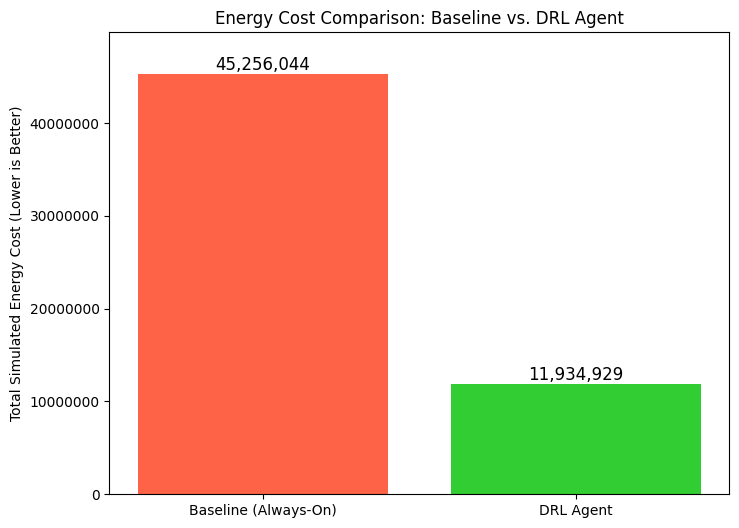

In [ ]:
import matplotlib.pyplot as plt

print("Generating Bar Chart for Cost Comparison...")

policies = ['Baseline (Always-On)', 'DRL Agent']
costs = [baseline_cost, agent_cost]
colors = ['#FF6347', '#32CD32'] # Red, Green

plt.figure(figsize=(8, 6))
bars = plt.bar(policies, costs, color=colors)
plt.ylabel('Total Simulated Energy Cost (Lower is Better)')
plt.title('Energy Cost Comparison: Baseline vs. DRL Agent')
plt.ticklabel_format(style='plain', axis='y') # No scientific notation

# Add numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval):,}',
             va='bottom', ha='center', fontsize=12)

plt.ylim(0, max(baseline_cost, agent_cost) * 1.1) # Add 10% padding at top
plt.show()

# **Generating Pie Chart for Savings Analysis**

Generating Pie Chart for Savings Analysis...


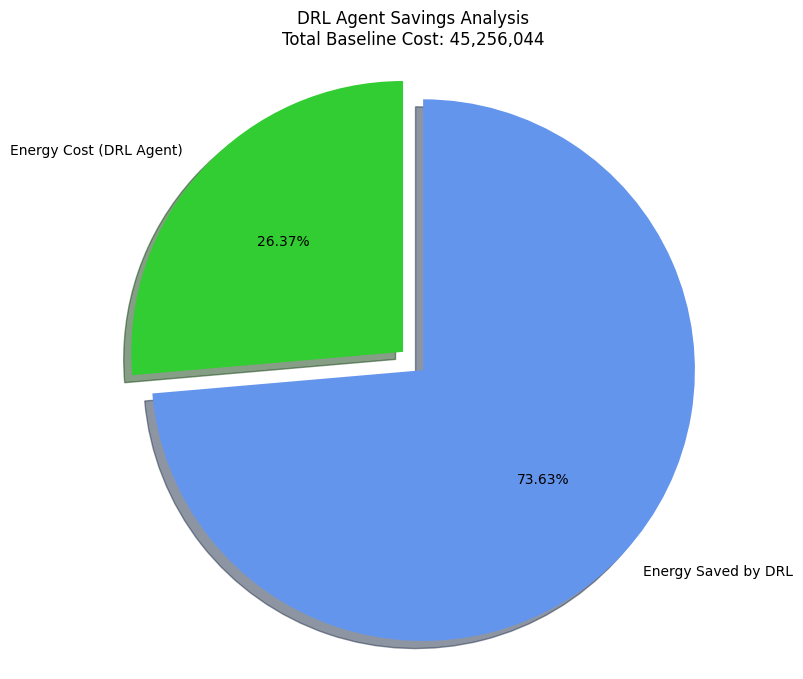

In [ ]:
import matplotlib.pyplot as plt

print("Generating Pie Chart for Savings Analysis...")

if baseline_cost > agent_cost:
    energy_saved = baseline_cost - agent_cost
    labels = [f'Energy Cost (DRL Agent)', 'Energy Saved by DRL']
    sizes = [agent_cost, energy_saved]
    colors = ['#32CD32', '#6495ED'] # Green, Blue
    explode = (0, 0.1)  # Explode the "Energy Saved" slice

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.2f%%', shadow=True, startangle=90)
    plt.title(f'DRL Agent Savings Analysis\nTotal Baseline Cost: {int(baseline_cost):,}')
    plt.axis('equal')
    plt.show()
else:
    print("Skipping Pie Chart because Agent Cost is not lower than Baseline.")

Generating Line Graph for Episode-by-Episode Cost...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

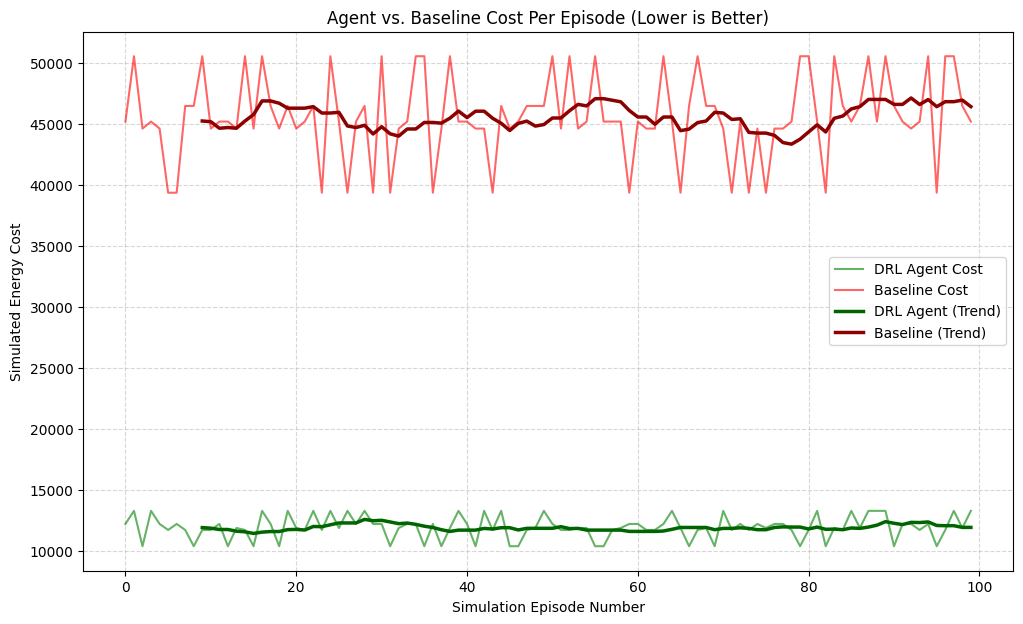

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("Generating Line Graph for Episode-by-Episode Cost...")

num_episodes_to_plot = 100
agent_episode_costs = []
baseline_episode_costs = []

# Run 100 episode simulation for DRL Agent
for _ in range(num_episodes_to_plot):
    obs = env.reset()
    done = False
    current_episode_cost = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        current_episode_cost += -reward[0]
    agent_episode_costs.append(current_episode_cost)

# Run 100 episode simulation for Baseline
for _ in range(num_episodes_to_plot):
    obs = env.reset()
    done = False
    current_episode_cost = 0
    while not done:
        action = [3]
        obs, reward, done, info = env.step(action)
        current_episode_cost += -reward[0]
    baseline_episode_costs.append(current_episode_cost)

# --- Plot the results ---
plt.figure(figsize=(12, 7))
plt.plot(agent_episode_costs, label='DRL Agent Cost', color='green', alpha=0.6)
plt.plot(baseline_episode_costs, label='Baseline Cost', color='red', alpha=0.6)

# Plot the moving average (trend) lines
window_size = 10
agent_ma = np.convolve(agent_episode_costs, np.ones(window_size)/window_size, mode='valid')
baseline_ma = np.convolve(baseline_episode_costs, np.ones(window_size)/window_size, mode='valid')

plt.plot(np.arange(window_size-1, num_episodes_to_plot), agent_ma,
         label='DRL Agent (Trend)', color='darkgreen', linewidth=2.5)
plt.plot(np.arange(window_size-1, num_episodes_to_plot), baseline_ma,
         label='Baseline (Trend)', color='darkred', linewidth=2.5)

plt.xlabel('Simulation Episode Number')
plt.ylabel('Simulated Energy Cost')
plt.title('Agent vs. Baseline Cost Per Episode (Lower is Better)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

--- Starting Sensitivity Analysis (This will take 20-30+ minutes) ---

--- Training new model for 20000 steps... ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Result for 20000 steps: 74.18% Saved

--- Training new model for 50000 steps... ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Result for 50000 steps: 74.00% Saved

--- Training new model for 100000 steps... ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Result for 100000 steps: 73.81% Saved

--- Training new model for 150000 steps... ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Result for 150000 steps: 74.17% Saved

--- Sensitivity Analysis Complete ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


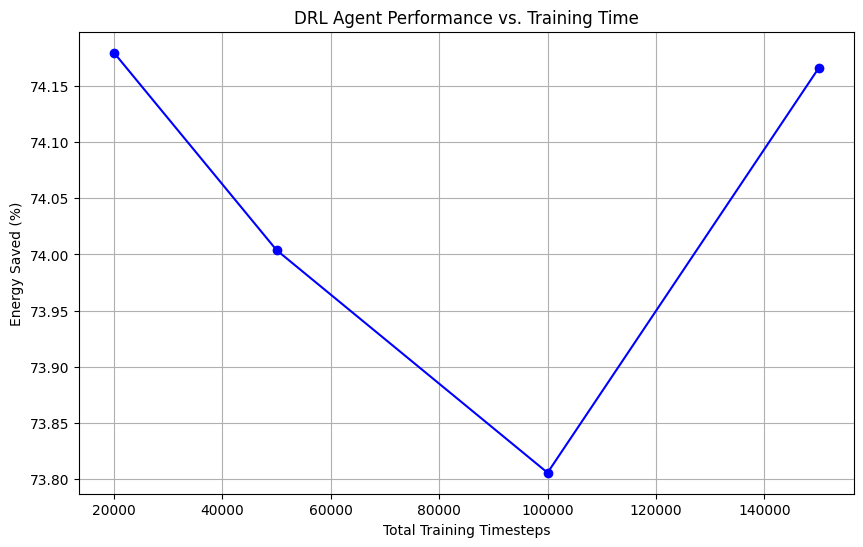

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

print("--- Starting Sensitivity Analysis (This will take 20-30+ minutes) ---")

timesteps_to_test = [20000, 50000, 100000, 150000] # List of training steps to test
results = []
num_episodes_for_eval = 1000 # Use 1000 episodes for a stable average

for timesteps in timesteps_to_test:
    print(f"\n--- Training new model for {timesteps} steps... ---")

    # 1. Create a fresh environment and a new model
    env = make_vec_env(DataCenterEnv, n_envs=1, env_kwargs={'forecast_dataframes_list': forecast_files})
    model = DQN("MlpPolicy", env, verbose=0, learning_starts=500, buffer_size=5000)

    # 2. Train the model
    model.learn(total_timesteps=timesteps, log_interval=None)

    # 3. Evaluate this new model (Agent)
    total_reward_agent = 0
    for _ in range(num_episodes_for_eval):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward_agent += reward[0]
    agent_cost = -total_reward_agent

    # 4. Evaluate (Baseline)
    total_reward_baseline = 0
    for _ in range(num_episodes_for_eval):
        obs = env.reset()
        done = False
        while not done:
            action = [3]
            obs, reward, done, info = env.step(action)
            total_reward_baseline += reward[0]
    baseline_cost = -total_reward_baseline

    # 5. Calculate results
    if baseline_cost > 0:
        energy_saved = baseline_cost - agent_cost
        percent_saved = (energy_saved / baseline_cost) * 100
    else:
        percent_saved = 0.0

    print(f"Result for {timesteps} steps: {percent_saved:.2f}% Saved")
    results.append({'timesteps': timesteps, 'percent_saved': percent_saved})

# --- 6. Plot the final Sensitivity Graph ---
print("\n--- Sensitivity Analysis Complete ---")
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['timesteps'], results_df['percent_saved'], marker='o', linestyle='-', color='b')
plt.title('DRL Agent Performance vs. Training Time')
plt.xlabel('Total Training Timesteps')
plt.ylabel('Energy Saved (%)')
plt.grid(True)
plt.show()